# Functions

In [31]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel

from os import listdir
from os.path import isdir, join

def visualize_classifier_data_old(data_path, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, dataset_plot_only=None, class_plot_only=None, highlight_best=False, 
                              plot_best_per_class=True):   

    dataset_names = {'Western-Europe':'WE', 'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Scandinavia': 'SC'}

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
    if dataset_plot_only is not None:
        all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

    all_dataset_stats = [f for f in listdir(join(data_path, 'dataset_stats')) if isdir(join(join(data_path, 'dataset_stats'), f))]
    results = dict()
    for dataset_dir in all_dataset_stats:
        all_splits_per_dataset_path = join(join(data_path, 'dataset_stats'), dataset_dir)
        all_dirs = [f for f in listdir(all_splits_per_dataset_path) if isdir(join(all_splits_per_dataset_path, f))]

        for dir_path in all_dirs:
            with open(join(join(join(data_path, 'dataset_stats'), dataset_dir), dir_path+'/stats.json'), 'r') as f:
                curr_stat = json.load(f)
                if dataset_dir not in results.keys():
                    results[dataset_dir] = [curr_stat['number_connected_components']]
                else:
                    results[dataset_dir].append(curr_stat['number_connected_components'])

    stats_dataset_name, stats_dataset_mean, stats_dataset_std = [], [], []
    for dataset_name, stats in results.items():
        stats_dataset_name.append(dataset_name)
        stats_dataset_mean.append(np.mean(stats))
        stats_dataset_std.append(np.std(stats))

    df = pd.DataFrame({
            'Dataset': [(dataset_names[name] + f' ({np.round(stats_dataset_mean[i], 1)})') for i, name in enumerate(stats_dataset_name)],
            'Number of components': np.round(stats_dataset_mean, 4),
            'std': stats_dataset_std
        })

    sns.set_theme()
    stats_bar_plot = sns.barplot(x='Dataset', y='Number of components', data=df, color='#05F140')
    for i, (mean, std) in enumerate(zip(df['Number of components'], df['std'])):
            stats_bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

            # Optionally annotate the bars with the exact mean values
            if annotate:
                stats_bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=6)

    plt.xticks(rotation=90, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=10)
    plt.title(f'Number of connected components in training graphs')
    plt.savefig(f'{fig_path}/train_connected_components_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()

    for dataset_dir in all_dataset_dirs:
        all_models_per_dataset_path = join(data_path, dataset_dir)
    
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]
        # print(all_dirs)

        results = dict()
        for dir_path in all_dirs:
            if True: #'relu' not in dir_path and 'gelu' not in dir_path and 'leaky_relu' not in dir_path and 'nw' not in dir_path:
                with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                    curr_res = json.load(f)
                    if 'graph_based' in dir_path:
                        ft = 'graph_based'
                    elif 'one_hot' in dir_path:
                        ft = 'one_hot'
                    else:
                        ft = ''
                    if tuple([curr_res['model_name'], ft]) not in results.keys():
                        results[tuple([curr_res['model_name'], ft])] = []
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])
                    else:
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])

        # print(results)

        classifiers = dict()
        for name_ft, metrics in results.items():
            name, ft = name_ft
            # print(len(metrics))
            classifiers[tuple([name, ft])] = []
            classifiers[tuple([name, ft])].append(np.mean(metrics))
            classifiers[tuple([name, ft])].append(np.std(metrics))
            classifiers[tuple([name, ft])].append(metrics)

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        
        for name_ft, metrics in classifiers.items():
            name, ft = name_ft
            all_fts.append(ft)
            classifier_names.append(name)
            means.append(metrics[0])
            std_devs.append(metrics[1])
            all_metrics.append(metrics[2])

        
        # Create a DataFrame for easier plotting with seaborn
        print('classifiers', len(classifier_names), len(means))
        df = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        # Optionally sort the bars by their mean values
        if sort_bars:
            df = df.sort_values('Mean', ascending=False)

        df = df.reset_index(drop=True)

        all_pvalues = []
        for i in range(df.shape[0]):
            if i == 0:
                all_pvalues.append(1)
            else:
                statistic, p_value = ttest_ind(df.iloc[0, 4], df.iloc[i, 4], equal_var=False)
                all_pvalues.append(p_value)

        n_tests = len(all_pvalues)
        all_pvalues = [p * n_tests for p in all_pvalues]



        # print(df)

        # Plotting
        if plot_best_per_class:
            plt.figure(figsize=(6, 6))
        else:
            plt.figure(figsize=(16, 6))
        # sns.set(style="whitegrid")
        sns.set_theme()
        
        cols, hue_names = [], []
        color_model_scheme = {'GNN graph based':'#05F140', 'GNN one hot':'#253957', 'MLP':'#FFB400', 'Heuristics':'#00B4D8', 'Community detection': '#EF233C'}#9B7EDE #FFDF64 #5FBFF9 #FF595E
        for index, row in df.iterrows():
            # print(row)
            model_name = row['Classifier']
            ft = row['feature_type']
            if 'MLP' in model_name:
                cols.append(color_model_scheme['MLP'])
                hue_names.append('MLP')
            elif ft == 'graph_based':
                cols.append(color_model_scheme['GNN graph based'])
                hue_names.append('GNN graph based')
            elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                cols.append(color_model_scheme['Heuristics'])
                hue_names.append('Heuristics')
            elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                cols.append(color_model_scheme['Community detection'])
                hue_names.append('Community detection')
            else:
                cols.append(color_model_scheme['GNN one hot'])
                hue_names.append('GNN one hot')

        one_best_model_per_class_df = []
        for u_n in np.unique(hue_names):
            current_df = df.loc[np.array(hue_names) == u_n]
            one_best_model_per_class_df.append(current_df.loc[[current_df['Mean'].idxmax()]])

        one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
        if plot_best_per_class:
            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(one_best_model_per_class_df.iloc[0, 4], one_best_model_per_class_df.iloc[i, 4], equal_var=False)
                    all_pvalues.append(p_value)

            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]
        print(one_best_model_per_class_df)

        if plot_best_per_class:
            one_best_model_per_class_hue_names = []
            for index, row in one_best_model_per_class_df.iterrows():
                # print(row)
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristics'])
                    one_best_model_per_class_hue_names.append('Heuristics')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    one_best_model_per_class_hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')
            bar_plot = sns.barplot(x=one_best_model_per_class_df.index, y=one_best_model_per_class_df.Mean, data=one_best_model_per_class_df, palette=color_model_scheme, hue=one_best_model_per_class_hue_names)
        else:
            bar_plot = sns.barplot(x=df.index, y=df.Mean, data=df, palette=color_model_scheme, hue=hue_names)  # , palette="viridis")

        # Collect all bars from all containers
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)

        # Create a list of bars with their center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]

        # Sort the bars based on their x-position
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])

        # Extract the sorted bars
        sorted_bars = [bar for bar, x in sorted_bars_with_x]

        # Apply hatching to the first six bars as they appear in the plot
        for i, bar in enumerate(sorted_bars):
            if all_pvalues[i] > 0.05:
                bar.set_hatch('//')
                bar.set_edgecolor('red')
                bar.set_linewidth(0)
            # else:
            #     print(all_pvalues[i])

        for i in range(len(bar_plot.containers)):
            bar_plot.bar_label(bar_plot.containers[i], label_type='center', rotation=90, color='white', fontsize=6)
        if plot_best_per_class:
            bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier)
        else:
            bar_plot.set_xticklabels(df.Classifier)
        # print(bar_plot.containers[0])
        
        if plot_best_per_class:
            # Adding error bars
            for i, (mean, std) in enumerate(zip(one_best_model_per_class_df['Mean'], one_best_model_per_class_df['StdDev'])):
                bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

                # Optionally annotate the bars with the exact mean values
                if annotate:
                    bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=6)
        else:
            # Adding error bars
            for i, (mean, std) in enumerate(zip(df['Mean'], df['StdDev'])):
                bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

                # Optionally annotate the bars with the exact mean values
                if annotate:
                    bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=6)


        
                
        
        # for k, v in color_model_scheme.items():
        #     if k != 'Community detection':
        #         plt.scatter([],[], c=v, label=k)

        if class_plot_only is None:
            plt.title(f'Model performance for dataset {dataset_names[dataset_dir]}')
        else:
            plt.title(f'Model performance for {dataset_dir} (class {class_plot_only})')
        plt.xlabel('Model')
        plt.ylabel('F1-macro score')
        plt.xticks(rotation=45, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=8)  # Rotate x-axis labels for better readability
        ax = plt.gca()
        for i in range(len(ax.get_xticklabels())):
            if ax.get_xticklabels()[i].get_text() in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                break
            else:
                plt.setp(ax.get_xticklabels()[i], color='red', weight='bold')

        if plot_best_per_class:
            plt.ylim(np.min(one_best_model_per_class_df['Mean'])-0.05, 1.05)
        plt.legend(fontsize='small')
        plt.tight_layout()  # Adjust the layout to make room for the rotated labels
        if fig_path is not None:
            if class_plot_only is None:
                plt.savefig(f'{fig_path}/{dataset_dir}_mask_percent_{mask_percent}.pdf', bbox_inches="tight")
            else:
                plt.savefig(f'{fig_path}/{dataset_dir}_mask_percent_{mask_percent}_{class_plot_only}.pdf', bbox_inches="tight")
        plt.show()


In [34]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from itertools import combinations

from os import listdir
from os.path import isdir, join

def visualize_classifier_data_nets_configurations(data_path, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, dataset_plot_only=None, class_plot_only=None, highlight_best=False, 
                              plot_best_per_class=True):   

    dataset_names = {'Western-Europe':'WE', 'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Scandinavia': 'SC'}

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
    if dataset_plot_only is not None:
        all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

    sns.set_theme()
    # Set up a new 2x2 layout figure for combined plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    ax_idx = 0
    all_handles, all_labels = [], []

    for dataset_dir in all_dataset_dirs:
        all_models_per_dataset_path = join(data_path, dataset_dir)
    
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]

        results = dict()
        for dir_path in all_dirs:
            if True:
                with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                    curr_res = json.load(f)
                    if 'graph_based' in dir_path:
                        ft = 'graph_based'
                    elif 'one_hot' in dir_path:
                        ft = 'one_hot'
                    else:
                        ft = ''
                    if tuple([curr_res['model_name'], ft]) not in results.keys():
                        results[tuple([curr_res['model_name'], ft])] = []
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])
                    else:
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])

        classifiers = dict()
        for name_ft, metrics in results.items():
            name, ft = name_ft
            classifiers[tuple([name, ft])] = []
            classifiers[tuple([name, ft])].append(np.mean(metrics))
            classifiers[tuple([name, ft])].append(np.std(metrics))
            classifiers[tuple([name, ft])].append(metrics)

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        
        for name_ft, metrics in classifiers.items():
            name, ft = name_ft
            all_fts.append(ft)
            classifier_names.append(name)
            means.append(metrics[0])
            std_devs.append(metrics[1])
            all_metrics.append(metrics[2])

        df = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        if sort_bars:
            df = df.sort_values('Mean', ascending=False)

        df = df.reset_index(drop=True)

        # cols, hue_names = [], []
        color_model_scheme = {'NN only': '#253957'}
        # for index, row in df.iterrows():
        #     model_name = row['Classifier']
        #     ft = row['feature_type']
        #     if 'MLP' in model_name:
        #         cols.append(color_model_scheme['MLP'])
        #         hue_names.append('MLP')
        #     elif ft == 'graph_based':
        #         cols.append(color_model_scheme['GNN graph based'])
        #         hue_names.append('GNN graph based')
        #     elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
        #         cols.append(color_model_scheme['Heuristic'])
        #         hue_names.append('Heuristic')
        #     elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
        #         cols.append(color_model_scheme['Community detection'])
        #         hue_names.append('Community detection')
        #     else:
        #         cols.append(color_model_scheme['GNN one hot'])
        #         hue_names.append('GNN one hot')

        # Create a new dataframe with specified rows and columns
        new_data = {'Classifier': [], 'Mean': [], 'StdDev': [], 'all_means': [], 'max_mean': []}

        arr = ['512h', '128h', '3l', '9l']
        combinations_list = ['_'.join(combo) for combo in combinations(arr, 2) if (combo[0].endswith('h') and combo[1].endswith('l')) or (combo[0].endswith('l') and combo[1].endswith('h'))]

        for combo in combinations_list:
            parts = combo.split('_')
            filtered_df = df[df['Classifier'].str.contains(parts[0]) & df['Classifier'].str.contains(parts[1]) & ~df['Classifier'].str.contains('relu') & ~df['Classifier'].str.contains('gelu') & ~df['Classifier'].str.contains('nw')]
            new_data['Classifier'].append(combo)
            new_data['Mean'].append(filtered_df['Mean'].mean())
            new_data['max_mean'].append(filtered_df['Mean'].max())
            new_data['StdDev'].append(filtered_df['Mean'].std())
            new_data['all_means'].append(filtered_df['Mean'].to_numpy().tolist())

        one_best_model_per_class_df = pd.DataFrame(new_data)
        # new_df.set_index('Classifier', inplace=True)

        if plot_best_per_class:
            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(one_best_model_per_class_df.iloc[0, 3], one_best_model_per_class_df.iloc[i, 3], equal_var=False)
                    all_pvalues.append(p_value)

            n_tests = len(all_pvalues)
            # print(n_tests)
            all_pvalues = [p * n_tests for p in all_pvalues]

            # one_best_model_per_class_hue_names = []
            # for index, row in one_best_model_per_class_df.iterrows():
            #     # print(row)
            #     model_name = row['Classifier']
            #     ft = row['feature_type']
            #     if 'MLP' in model_name:
            #         cols.append(color_model_scheme['MLP'])
            #         one_best_model_per_class_hue_names.append('MLP')
            #     elif ft == 'graph_based':
            #         cols.append(color_model_scheme['GNN graph based'])
            #         one_best_model_per_class_hue_names.append('GNN graph based')
            #     elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
            #         cols.append(color_model_scheme['Heuristic'])
            #         one_best_model_per_class_hue_names.append('Heuristic')
            #     elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
            #         cols.append(color_model_scheme['Community detection'])
            #         one_best_model_per_class_hue_names.append('Community detection')
            #     else:
            #         cols.append(color_model_scheme['GNN one hot'])
            #         one_best_model_per_class_hue_names.append('GNN one hot')

        ax = axs[ax_idx // 2, ax_idx % 2]

        # print(one_best_model_per_class_df)

        bar_plot = sns.barplot(x=one_best_model_per_class_df.index, y=one_best_model_per_class_df.Mean, data=one_best_model_per_class_df, color='#253957', ax=ax,
                               legend=None)
        
        ax.scatter([i for i in range(4)], one_best_model_per_class_df.max_mean, color='red', marker='o', s=50, zorder=3)
        
        # Collect all bars from all containers
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)

        # Create a list of bars with their center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]

        # Sort the bars based on their x-position
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])

        # Extract the sorted bars
        sorted_bars = [bar for bar, x in sorted_bars_with_x]

        # Apply hatching to the first six bars as they appear in the plot
        for i, bar in enumerate(sorted_bars):
            if all_pvalues[i] > 0.05:
                bar.set_hatch('//')
                bar.set_edgecolor('red')
                bar.set_linewidth(0)
            # else:
            #     print(all_pvalues[i])
        
        for i in range(len(bar_plot.containers)):
            bar_plot.bar_label(bar_plot.containers[i], fmt='%.4f', label_type='center', rotation=90, color='white', fontsize=10)

        for i, (mean, std) in enumerate(zip(one_best_model_per_class_df['Mean'], one_best_model_per_class_df['StdDev'])):
            ax.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

            if annotate:
                ax.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=10)

        bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
        ax.set_title(f'{dataset_names[dataset_dir]}')
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Collect legend handles and labels from the current color scheme
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        # for i in range(len(ax.get_xticklabels())):
        #     if ax.get_xticklabels()[i].get_text() in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
        #         break
        #     else:
        #         plt.setp(ax.get_xticklabels()[i], color='red', weight='bold')

        ax.set_yticks([i * 0.05 for i in range(21)])
        ax.set_ylim(np.min(one_best_model_per_class_df['Mean'])-0.3, 1.1)

        ax_idx += 1

    # Remove duplicate handles and labels by creating a unique set
    unique_handles_labels = dict(zip(all_labels, all_handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', ncol=5, fontsize='medium')
    # Add common X and Y labels
    fig.text(0.5, -0.05, 'Model type', ha='center', fontsize=14)
    fig.text(-0.05, 0.5, 'F1-macro score', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()


In [35]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from itertools import combinations

from os import listdir
from os.path import isdir, join

def visualize_classifier_data_edge_weights(data_path, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, dataset_plot_only=None, class_plot_only=None, highlight_best=False, 
                              plot_best_per_class=True):   

    dataset_names = {'Western-Europe':'WE', 'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Scandinavia': 'SC'}

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
    if dataset_plot_only is not None:
        all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

    sns.set_theme()
    # Set up a new 2x2 layout figure for combined plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    ax_idx = 0
    all_handles, all_labels = [], []

    for dataset_dir in all_dataset_dirs:
        all_models_per_dataset_path = join(data_path, dataset_dir)
    
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]

        results = dict()
        for dir_path in all_dirs:
            if True:
                with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                    curr_res = json.load(f)
                    if 'graph_based' in dir_path:
                        ft = 'graph_based'
                    elif 'one_hot' in dir_path:
                        ft = 'one_hot'
                    else:
                        ft = ''
                    if tuple([curr_res['model_name'], ft]) not in results.keys():
                        results[tuple([curr_res['model_name'], ft])] = []
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])
                    else:
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])

        classifiers = dict()
        for name_ft, metrics in results.items():
            name, ft = name_ft
            classifiers[tuple([name, ft])] = []
            classifiers[tuple([name, ft])].append(np.mean(metrics))
            classifiers[tuple([name, ft])].append(np.std(metrics))
            classifiers[tuple([name, ft])].append(metrics)

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        
        for name_ft, metrics in classifiers.items():
            name, ft = name_ft
            all_fts.append(ft)
            classifier_names.append(name)
            means.append(metrics[0])
            std_devs.append(metrics[1])
            all_metrics.append(metrics[2])

        df = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        if sort_bars:
            df = df.sort_values('Mean', ascending=False)

        df = df.reset_index(drop=True)

        # cols, hue_names = [], []
        color_model_scheme = {'NN only': '#253957'}
        # for index, row in df.iterrows():
        #     model_name = row['Classifier']
        #     ft = row['feature_type']
        #     if 'MLP' in model_name:
        #         cols.append(color_model_scheme['MLP'])
        #         hue_names.append('MLP')
        #     elif ft == 'graph_based':
        #         cols.append(color_model_scheme['GNN graph based'])
        #         hue_names.append('GNN graph based')
        #     elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
        #         cols.append(color_model_scheme['Heuristic'])
        #         hue_names.append('Heuristic')
        #     elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
        #         cols.append(color_model_scheme['Community detection'])
        #         hue_names.append('Community detection')
        #     else:
        #         cols.append(color_model_scheme['GNN one hot'])
        #         hue_names.append('GNN one hot')

        # Create a new dataframe with specified rows and columns
        new_data = {'Classifier': [], 'Mean': [], 'StdDev': [], 'all_means': [], 'max_mean': []}

        arr_map = {'with_edge_weights': 'w', 'without_edge_weights': 'nw'}
        combinations_list = ['with_edge_weights', 'without_edge_weights']

        for combo in combinations_list:
            filtered_df = df[df['Classifier'].str.contains(arr_map[combo]) & df['Classifier'].str.contains('gnorm')]
            new_data['Classifier'].append(combo)
            new_data['Mean'].append(filtered_df['Mean'].mean())
            new_data['max_mean'].append(filtered_df['Mean'].max())
            new_data['StdDev'].append(filtered_df['Mean'].std())
            new_data['all_means'].append(filtered_df['Mean'].to_numpy().tolist())

        one_best_model_per_class_df = pd.DataFrame(new_data)
        # new_df.set_index('Classifier', inplace=True)

        if plot_best_per_class:
            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(one_best_model_per_class_df.iloc[0, 3], one_best_model_per_class_df.iloc[i, 3], equal_var=False)
                    all_pvalues.append(p_value)

            n_tests = len(all_pvalues)
            # print(n_tests)
            all_pvalues = [p * n_tests for p in all_pvalues]

            # one_best_model_per_class_hue_names = []
            # for index, row in one_best_model_per_class_df.iterrows():
            #     # print(row)
            #     model_name = row['Classifier']
            #     ft = row['feature_type']
            #     if 'MLP' in model_name:
            #         cols.append(color_model_scheme['MLP'])
            #         one_best_model_per_class_hue_names.append('MLP')
            #     elif ft == 'graph_based':
            #         cols.append(color_model_scheme['GNN graph based'])
            #         one_best_model_per_class_hue_names.append('GNN graph based')
            #     elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
            #         cols.append(color_model_scheme['Heuristic'])
            #         one_best_model_per_class_hue_names.append('Heuristic')
            #     elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
            #         cols.append(color_model_scheme['Community detection'])
            #         one_best_model_per_class_hue_names.append('Community detection')
            #     else:
            #         cols.append(color_model_scheme['GNN one hot'])
            #         one_best_model_per_class_hue_names.append('GNN one hot')

        ax = axs[ax_idx // 2, ax_idx % 2]

        # print(one_best_model_per_class_df)

        bar_plot = sns.barplot(x=one_best_model_per_class_df.index, y=one_best_model_per_class_df.Mean, data=one_best_model_per_class_df, color='#253957', ax=ax,
                               legend=None)
        
        ax.scatter([i for i in range(2)], one_best_model_per_class_df.max_mean, color='red', marker='o', s=50, zorder=3)
        
        # Collect all bars from all containers
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)

        # Create a list of bars with their center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]

        # Sort the bars based on their x-position
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])

        # Extract the sorted bars
        sorted_bars = [bar for bar, x in sorted_bars_with_x]

        # Apply hatching to the first six bars as they appear in the plot
        for i, bar in enumerate(sorted_bars):
            if all_pvalues[i] > 0.05:
                bar.set_hatch('//')
                bar.set_edgecolor('red')
                bar.set_linewidth(0)
            # else:
            #     print(all_pvalues[i])
        
        for i in range(len(bar_plot.containers)):
            bar_plot.bar_label(bar_plot.containers[i], fmt='%.4f', label_type='center', rotation=90, color='white', fontsize=10)

        for i, (mean, std) in enumerate(zip(one_best_model_per_class_df['Mean'], one_best_model_per_class_df['StdDev'])):
            ax.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

            if annotate:
                ax.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=10)

        bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
        ax.set_title(f'{dataset_names[dataset_dir]}')
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Collect legend handles and labels from the current color scheme
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        # for i in range(len(ax.get_xticklabels())):
        #     if ax.get_xticklabels()[i].get_text() in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
        #         break
        #     else:
        #         plt.setp(ax.get_xticklabels()[i], color='red', weight='bold')

        ax.set_yticks([i * 0.05 for i in range(21)])
        ax.set_ylim(np.min(one_best_model_per_class_df['Mean'])-0.05, 1.05)

        ax_idx += 1

    # Remove duplicate handles and labels by creating a unique set
    unique_handles_labels = dict(zip(all_labels, all_handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', ncol=5, fontsize='medium')
    # Add common X and Y labels
    fig.text(0.5, -0.05, 'Model type', ha='center', fontsize=14)
    fig.text(-0.05, 0.5, 'F1-macro score', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()


In [36]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel

from os import listdir
from os.path import isdir, join

def visualize_classifier_data_different_losses(data_path, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, dataset_plot_only=None, class_plot_only=None, highlight_best=False, 
                              plot_best_per_class=True):   

    dataset_names = {'Western-Europe':'WE', 'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Scandinavia': 'SC'}

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
    if dataset_plot_only is not None:
        all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

    sns.set_theme()
    # Set up a new 2x2 layout figure for combined plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    ax_idx = 0
    all_handles, all_labels = [], []

    for dataset_dir in all_dataset_dirs:
        all_models_per_dataset_path = join(data_path, dataset_dir)
    
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]

        results = dict()
        for dir_path in all_dirs:
            if True:
                with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                    curr_res = json.load(f)
                    if 'graph_based' in dir_path:
                        ft = 'graph_based'
                    elif 'one_hot' in dir_path:
                        ft = 'one_hot'
                    else:
                        ft = ''
                    if tuple([curr_res['model_name'], ft]) not in results.keys():
                        results[tuple([curr_res['model_name'], ft])] = []
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])
                    else:
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])

        classifiers = dict()
        for name_ft, metrics in results.items():
            name, ft = name_ft
            classifiers[tuple([name, ft])] = []
            classifiers[tuple([name, ft])].append(np.mean(metrics))
            classifiers[tuple([name, ft])].append(np.std(metrics))
            classifiers[tuple([name, ft])].append(metrics)

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        
        for name_ft, metrics in classifiers.items():
            name, ft = name_ft
            all_fts.append(ft)
            classifier_names.append(name)
            means.append(metrics[0])
            std_devs.append(metrics[1])
            all_metrics.append(metrics[2])

        df = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        if sort_bars:
            df = df.sort_values('Mean', ascending=False)

        df = df.reset_index(drop=True)

        cols, hue_names = [], []
        color_model_scheme = {'GNN one hot':'#253957', 'GNN graph based':'#05F140'}
        # for index, row in df.iterrows():
        #     model_name = row['Classifier']
        #     ft = row['feature_type']
        #     if 'MLP' in model_name:
        #         cols.append(color_model_scheme['MLP'])
        #         hue_names.append('MLP')
        #     elif ft == 'graph_based':
        #         cols.append(color_model_scheme['GNN graph based'])
        #         hue_names.append('GNN graph based')
        #     elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
        #         cols.append(color_model_scheme['Heuristic'])
        #         hue_names.append('Heuristic')
        #     elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
        #         cols.append(color_model_scheme['Community detection'])
        #         hue_names.append('Community detection')
        #     else:
        #         cols.append(color_model_scheme['GNN one hot'])
        #         hue_names.append('GNN one hot')

        one_best_model_per_class_df = []
        one_best_model_hue_names = []
        for u_n in ['GL_TAGConv_3l_512h_w_k3_gnorm', 'GL_TAGConv_3l_512h_w_k3_gnorm_gelu', 'GL_TAGConv_3l_512h_w_k3_gnorm_leaky_relu', 'GL_TAGConv_3l_512h_w_k3_gnorm_relu']:
            best_model = df.loc[df['Classifier'] == u_n]
            one_best_model_per_class_df.append(best_model)
            one_best_model_hue_names.append(u_n)

        one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
        if plot_best_per_class:
            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(one_best_model_per_class_df.iloc[0, 4], one_best_model_per_class_df.iloc[i, 4], equal_var=False)
                    all_pvalues.append(p_value)

            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]

            one_best_model_per_class_hue_names = []
            for index, row in one_best_model_per_class_df.iterrows():
                # print(row)
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristic'])
                    one_best_model_per_class_hue_names.append('Heuristic')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    one_best_model_per_class_hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')

        ax = axs[ax_idx // 2, ax_idx % 2]

        # print(one_best_model_per_class_df)

        bar_plot = sns.barplot(x=one_best_model_per_class_df.index, y=one_best_model_per_class_df.Mean, data=one_best_model_per_class_df, palette=color_model_scheme, hue=one_best_model_per_class_hue_names, ax=ax,
                               legend=None)
        
        # Collect all bars from all containers
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)

        # Create a list of bars with their center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]

        # Sort the bars based on their x-position
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])

        # Extract the sorted bars
        sorted_bars = [bar for bar, x in sorted_bars_with_x]

        # Apply hatching to the first six bars as they appear in the plot
        for i, bar in enumerate(sorted_bars):
            if all_pvalues[i] > 0.05:
                bar.set_hatch('//')
                bar.set_edgecolor('red')
                bar.set_linewidth(0)
            # else:
            #     print(all_pvalues[i])
        
        for i in range(len(bar_plot.containers)):
            bar_plot.bar_label(bar_plot.containers[i], label_type='center', rotation=90, color='white', fontsize=10)

        for i, (mean, std) in enumerate(zip(one_best_model_per_class_df['Mean'], one_best_model_per_class_df['StdDev'])):
            ax.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

            if annotate:
                ax.text(i, mean + std + 0.002, f'{std:.2f}', ha='center', va='bottom', fontsize=10)

        bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
        ax.set_title(f'{dataset_names[dataset_dir]}')
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Collect legend handles and labels from the current color scheme
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        ax.set_yticks([i * 0.05 for i in range(21)])
        ax.set_ylim(np.min(one_best_model_per_class_df['Mean'])-0.05, 1.02)

        ax_idx += 1

    # Remove duplicate handles and labels by creating a unique set
    unique_handles_labels = dict(zip(all_labels, all_handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', ncol=2, fontsize='medium')
    # Add common X and Y labels
    fig.text(0.5, -0.05, 'Model', ha='center', fontsize=14)
    fig.text(-0.05, 0.5, 'F1-macro score', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()


In [1]:
import json
import numpy as np
from os import listdir
from os.path import isdir, join
import matplotlib.pyplot as plt
import itertools

In [30]:
def plot_test_2(data_path):

    # Initialize dictionaries for means and stds
    predictions = dict()
    predictions_std = dict()
    predictions['x'] = []

    # Loop over dataset directories
    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    for dataset_dir in all_dataset_dirs:
        # Calculate the x value from the dataset directory name
        predictions['x'].append(float(dataset_dir.split('_')[-1]) / 100)
        tmp_predictions = dict()
        all_models_per_dataset_path = join(data_path, dataset_dir)
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]
        for dir_path in all_dirs:
            with open(join(all_models_per_dataset_path, dir_path, 'results.json'), 'r') as f:
                curr_res = json.load(f)
            key = dir_path[:-8]  # key extracted from directory name
            if key not in tmp_predictions:
                tmp_predictions[key] = [curr_res['f1_macro']]
            else:
                tmp_predictions[key].append(curr_res['f1_macro'])
                
        # For each key, calculate the mean and std
        for tpk in tmp_predictions.keys():
            mean_val = np.mean(tmp_predictions[tpk])
            std_val = np.std(tmp_predictions[tpk])
            if tpk not in predictions:
                predictions[tpk] = [mean_val]
                predictions_std[tpk] = [std_val]
            else:
                predictions[tpk].append(mean_val)
                predictions_std[tpk].append(std_val)

    # Create the plot
    fig, ax = plt.subplots(figsize=(18, 10))

    # Compute sorted order based on the x-values (the independent variable)
    arg_sort = np.argsort(predictions['x'])
    x_labels = np.array(predictions['x'])[arg_sort]
    # Normalize the x-axis positions
    x_plot = np.arange(len(x_labels)) / np.max(np.arange(len(x_labels)))

    # Set up a cycle for distinct colors for non-special lines
    color_cycle = itertools.cycle(plt.get_cmap("tab10").colors)

    # Loop over each key (excluding 'x' and 'pos')
    for k in predictions.keys():
        if k != 'x' and k != 'pos':
            mean_vals = np.array(predictions[k])[arg_sort]
            std_vals = np.array(predictions_std[k])[arg_sort] if k in predictions_std else np.zeros_like(mean_vals)
            # Check if this is the special line that should be red and bold
            if k == "GL_TAGConv_3l_512h_w_k3_gnorm_one_hot":
                color = 'red'
                lw = 3  # Thicker line
            else:
                color = next(color_cycle)
                lw = 2
            # Plot the std error band as a filled region behind the mean line
            ax.fill_between(x_plot, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2, color=color)
            # Plot the mean values with markers
            ax.plot(x_plot, mean_vals, '-o', label=k, color=color, linewidth=lw)

    # Set the labels and tick properties
    plt.xlabel('edge probabilites matrix multiplying constant', fontsize=24)
    plt.ylabel('f1-macro score', fontsize=24)
    ax.set_xticks(x_plot)
    ax.set_xticklabels(x_labels)
    plt.xticks(rotation=90, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()
    plt.grid()
    plt.savefig('/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures/dependencier_test_2.pdf', bbox_inches="tight")
    plt.show()


In [31]:
def plot_test_1(data_path, running_params):

    # Load running parameters and initialize predictions dictionaries
    predictions = dict()
    predictions_std = dict()
    with open(running_params, 'r') as f:
        running_params_dict = json.load(f)
    predictions['pos'] = running_params_dict['sub_train_size']
    predictions['x'] = []

    # Loop over dataset directories
    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    for dataset_dir in all_dataset_dirs:
        predictions['x'].append(float(dataset_dir.split('_')[-1]))
        tmp_predictions = dict()
        all_models_per_dataset_path = join(data_path, dataset_dir)
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]
        for dir_path in all_dirs:
            with open(join(all_models_per_dataset_path, dir_path, 'results.json'), 'r') as f:
                curr_res = json.load(f)
            key = dir_path[:-8]
            if key not in tmp_predictions:
                tmp_predictions[key] = [curr_res['f1_macro']]
            else:
                tmp_predictions[key].append(curr_res['f1_macro'])
        
        # For each key, compute mean and standard deviation, and store them
        for tpk in tmp_predictions.keys():
            mean_val = np.mean(tmp_predictions[tpk])
            std_val = np.std(tmp_predictions[tpk])
            if tpk not in predictions:
                predictions[tpk] = [mean_val]
                predictions_std[tpk] = [std_val]
            else:
                predictions[tpk].append(mean_val)
                predictions_std[tpk].append(std_val)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(18, 10))
    
    # Compute sorted order based on x-values and normalize x positions
    arg_sort = np.argsort(predictions['x'])
    x_labels = np.array(predictions['x'])[arg_sort]
    x_plot = np.arange(len(x_labels)) / np.max(np.arange(len(x_labels)))
    
    # Setup a color cycle for distinct colors
    color_cycle = itertools.cycle(plt.get_cmap("tab10").colors)
    
    # Loop over each prediction key and plot mean lines with std bands
    for k in predictions.keys():
        if k != 'x' and k != 'pos':
            mean_vals = np.array(predictions[k])[arg_sort]
            std_vals = np.array(predictions_std[k])[arg_sort] if k in predictions_std else np.zeros_like(mean_vals)
            # Check if the current key is the special one
            if k == "GL_TAGConv_3l_512h_w_k3_gnorm_one_hot":
                color = 'red'
                lw = 3  # Thicker line for the special key
            else:
                color = next(color_cycle)
                lw = 2
            # Plot the standard deviation band
            ax.fill_between(x_plot, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2, color=color)
            # Plot the mean line with markers
            ax.plot(x_plot, mean_vals, '-o', label=k, color=color, linewidth=lw)

    plt.xlabel('part of training data', fontsize=24)
    plt.ylabel('f1-macro score', fontsize=24)
    ax.set_xticks(x_plot)
    ax.set_xticklabels(x_labels)
    plt.xticks(rotation=90, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()
    plt.grid()
    plt.savefig('/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures/dependencier_test_1.pdf', bbox_inches="tight")
    plt.show()


# Pictures

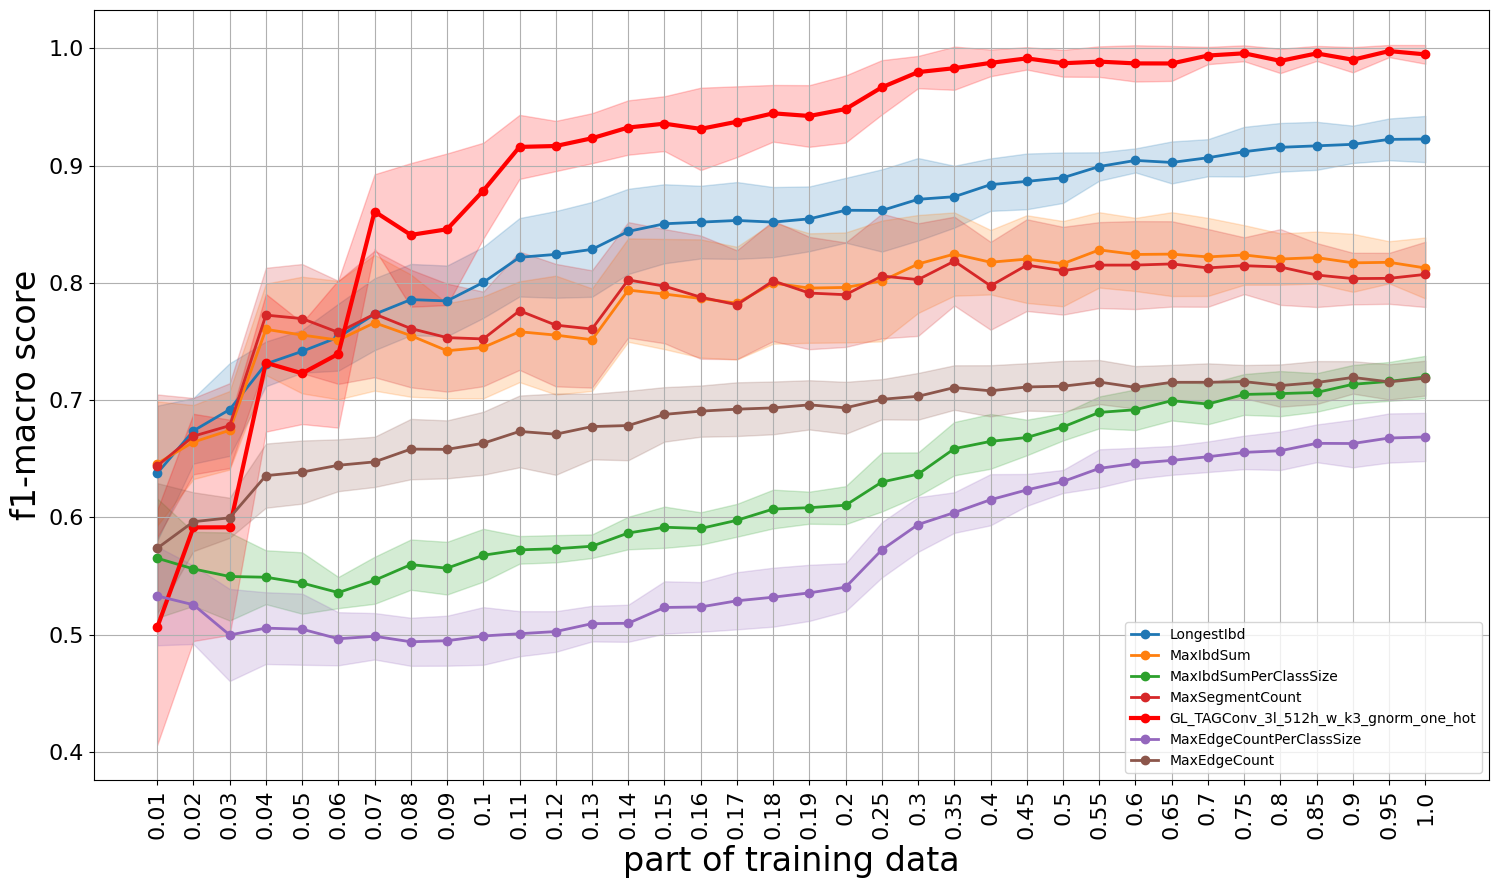

In [32]:
plot_test_1('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/dependensier_test_1', '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/dependensier_test_1/running_params.json')

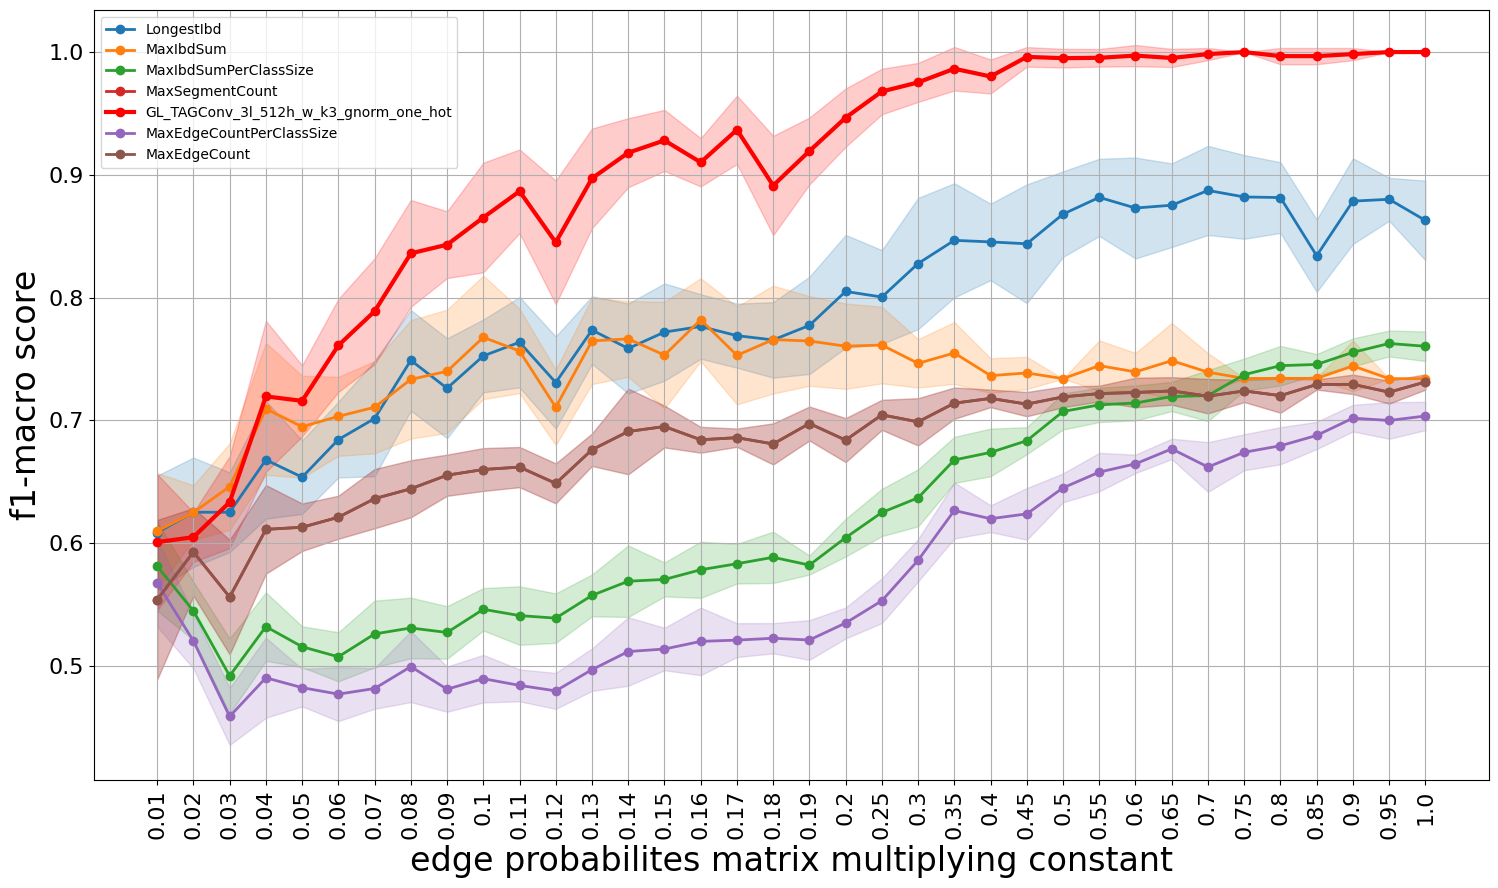

In [33]:
plot_test_2('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_simulation_decreaser')

In [2]:
def visualize_classifier_data_diagonal_changer(data_path):

    # Initialize dictionaries for means and stds
    predictions = dict()
    predictions_std = dict()
    predictions['x'] = []

    # Loop over dataset directories
    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    for dataset_dir in all_dataset_dirs:
        # Calculate the x value from the dataset directory name
        predictions['x'].append(float(dataset_dir.split('_')[-1]) / 100)
        tmp_predictions = dict()
        all_models_per_dataset_path = join(data_path, dataset_dir)
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]
        for dir_path in all_dirs:
            with open(join(all_models_per_dataset_path, dir_path, 'results.json'), 'r') as f:
                curr_res = json.load(f)
            key = dir_path[:-8]  # key extracted from directory name
            if key not in tmp_predictions:
                tmp_predictions[key] = [curr_res['f1_macro']]
            else:
                tmp_predictions[key].append(curr_res['f1_macro'])
                
        # For each key, calculate the mean and std
        for tpk in tmp_predictions.keys():
            mean_val = np.mean(tmp_predictions[tpk])
            std_val = np.std(tmp_predictions[tpk])
            if tpk not in predictions:
                predictions[tpk] = [mean_val]
                predictions_std[tpk] = [std_val]
            else:
                predictions[tpk].append(mean_val)
                predictions_std[tpk].append(std_val)

    # Create the plot
    fig, ax = plt.subplots(figsize=(18, 10))

    # Compute sorted order based on the x-values (the independent variable)
    arg_sort = np.argsort(predictions['x'])
    x_labels = np.array(predictions['x'])[arg_sort]
    # Normalize the x-axis positions
    x_plot = np.arange(len(x_labels)) / np.max(np.arange(len(x_labels)))

    # Set up a cycle for distinct colors for non-special lines
    color_cycle = itertools.cycle(plt.get_cmap("tab10").colors)

    # Loop over each key (excluding 'x' and 'pos')
    for k in predictions.keys():
        if k != 'x' and k != 'pos':
            mean_vals = np.array(predictions[k])[arg_sort]
            std_vals = np.array(predictions_std[k])[arg_sort] if k in predictions_std else np.zeros_like(mean_vals)
            # Check if this is the special line that should be red and bold
            if k == "GL_TAGConv_3l_512h_w_k3_gnorm_one_hot":
                color = 'red'
                lw = 3  # Thicker line
            else:
                color = next(color_cycle)
                lw = 2
            # Plot the std error band as a filled region behind the mean line
            ax.fill_between(x_plot, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2, color=color)
            # Plot the mean values with markers
            ax.plot(x_plot, mean_vals, '-o', label=k, color=color, linewidth=lw)

    # Set the labels and tick properties
    plt.xlabel('diagonal probability multiplying constant', fontsize=24)
    plt.ylabel('f1-macro score', fontsize=24)
    ax.set_xticks(x_plot)
    ax.set_xticklabels(x_labels)
    plt.xticks(rotation=90, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()
    plt.grid()
    plt.savefig('/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures/diagonal_changer.pdf', bbox_inches="tight")
    plt.show()


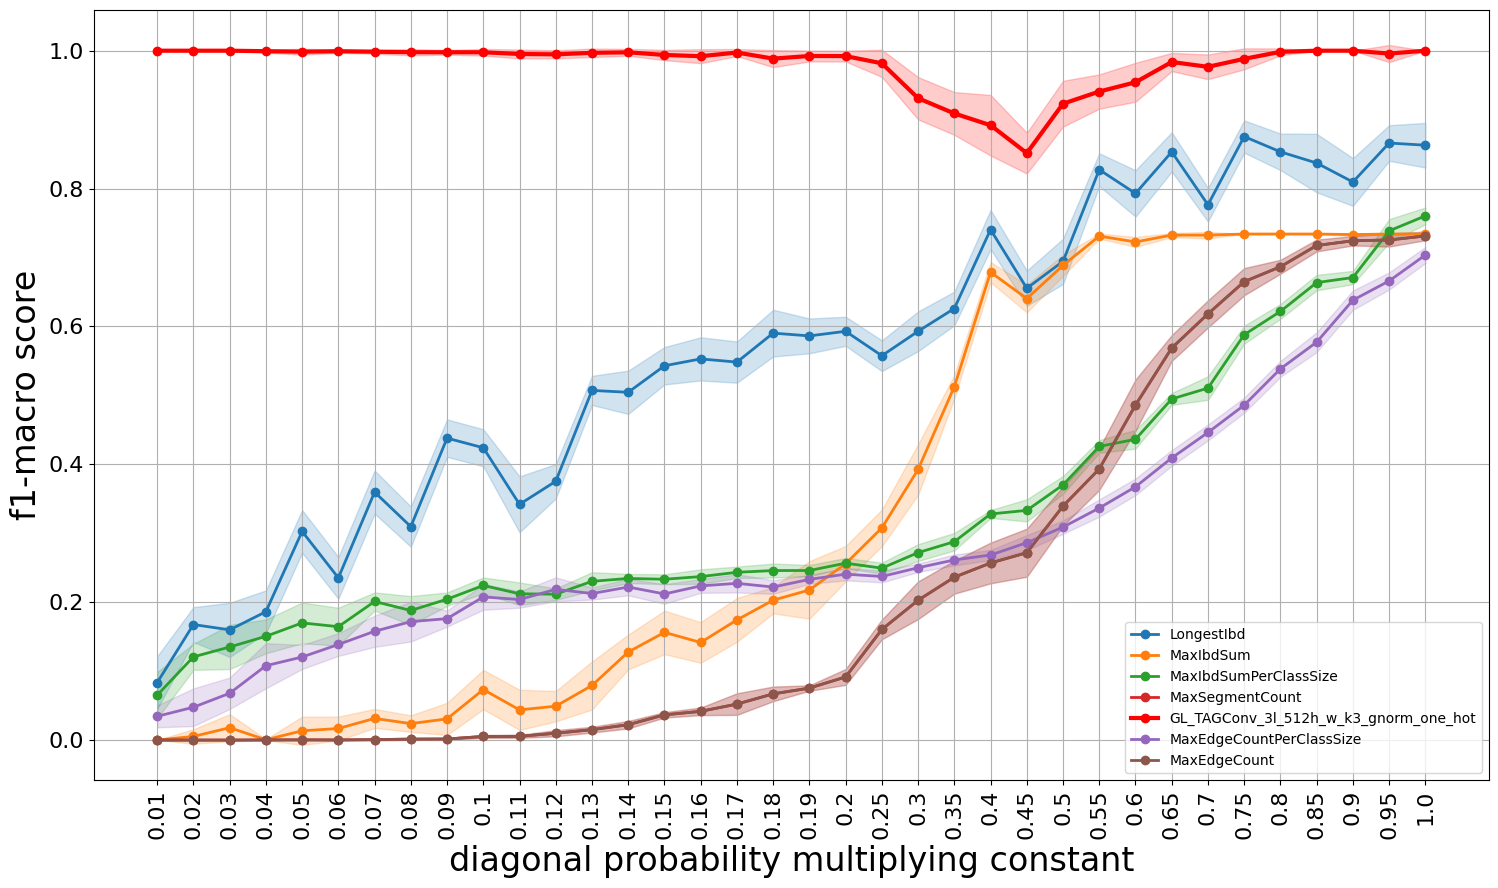

In [3]:
visualize_classifier_data_diagonal_changer('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_simulation_diagonal_changer')

Interpolation

In [22]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from os import listdir
from os.path import isdir, join

def visualize_classifier_data_interpolation(data_path, fig_path):
    """
    Creates one figure with combined classifier performance across multiple datasets.
    Bars are shown only for:
      - GNN one hot
      - GNN graph based
      - Heuristic

    Bars for each dataset appear in the order [GNN one hot, GNN graph based, Heuristic].
    Short labels are formed as '{datasetAbbrev}#i', where i is 0, 1, or 2, matching
    that group ordering.
    The legend is placed above the main figure, centered.

    An extra dictionary is printed mapping datasetName_modelName -> shortLabel.
    """

    # Define dataset directory -> short name
    dataset_names = {
        'CR_class_balance_interpolation_step_0': 'step_0', 
        'CR_class_balance_interpolation_step_1': 'step_1', 
        'CR_class_balance_interpolation_step_2': 'step_2', 
        'CR_class_balance_interpolation_step_3': 'step_3', 
        'CR_class_balance_interpolation_step_4': 'step_4',
        'CR_class_balance_interpolation_step_5': 'step_5'
    }

    # Only use directories present in dataset_names
    all_dataset_dirs = [
        d for d in listdir(data_path) 
        if isdir(join(data_path, d)) and d in dataset_names
    ]
    print("Datasets found:", all_dataset_dirs)

    # We want only these three groups, in this strict order.
    groups_order = ["GNN one hot", "GNN graph based", "Heuristic"]
    group_to_color = {
        "GNN one hot":     "#253957",
        "GNN graph based": "#05F140",
        "Heuristic":       "#00B4D8"
    }
    # Map each group to its index: 0, 1, 2
    group_to_index = {g: i for i, g in enumerate(groups_order)}

    # Dictionary to store the real->short model name mapping
    model_mapping = {}

    combined_data = []

    # -----------------------------------------------------------
    #  STEP 1: Collect best models for each group in each dataset
    # -----------------------------------------------------------
    for dataset_dir in all_dataset_dirs:
        ds_abbrev = dataset_names[dataset_dir]
        ds_path   = join(data_path, dataset_dir)
        sub_dirs  = [f for f in listdir(ds_path) if isdir(join(ds_path, f))]

        results_dict = {}
        for dir_path in sub_dirs:
            with open(join(ds_path, dir_path, 'results.json'), 'r') as f:
                curr_res = json.load(f)

            # Determine model's "group" from directory or name
            if 'graph_based' in dir_path:
                ft = 'graph_based'
            elif 'one_hot' in dir_path:
                ft = 'one_hot'
            else:
                ft = ''

            # Convert it to one of the 3 groups
            if 'MLP' in curr_res['model_name']:
                group = 'MLP'
            elif ft == 'graph_based':
                group = 'GNN graph based'
            elif curr_res['model_name'] in [
                'MaxEdgeCount','MaxEdgeCountPerClassSize','MaxIbdSum',
                'MaxIbdSumPerClassSize','LongestIbd','MaxSegmentCount'
            ]:
                group = 'Heuristic'
            elif curr_res['model_name'] in [
                'AgglomerativeClustering','GirvanNewmann','LabelPropagation',
                'MultiRankWalk','RelationalNeighborClassifier','RidgeRegression','SpectralClustering'
            ]:
                group = 'Community detection'
            else:
                group = 'GNN one hot'

            if group not in group_to_color:
                continue

            key = (group, curr_res['model_name'], ft)
            results_dict.setdefault(key, []).append(curr_res['f1_macro'])

        if not results_dict:
            # No valid classifiers for this dataset
            continue

        # Compute mean/std per unique (group, model_name, ft)
        data_rows = []
        for (group, model_name, ft), metrics in results_dict.items():
            mean_ = np.mean(metrics)
            std_  = np.std(metrics)
            data_rows.append({
                "Group"       : group,
                "ModelName"   : model_name,
                "FeatureType" : ft,
                "Mean"        : mean_,
                "StdDev"      : std_,
                "MetricsList" : metrics
            })

        df_all = pd.DataFrame(data_rows)
        # For each group, find the row with highest mean
        best_rows = []
        for g in groups_order:
            subset = df_all[df_all["Group"] == g]
            if subset.empty:
                continue
            idxmax = subset["Mean"].idxmax()
            best_rows.append(subset.loc[idxmax])

        if not best_rows:
            continue

        df_best = pd.DataFrame(best_rows).reset_index(drop=True)

        # Create short labels in the order GNN one hot (#0), GNN graph based (#1), Heuristic (#2)
        short_labels = []
        for i, row in df_best.iterrows():
            grp = row["Group"]
            idx = group_to_index[grp]  # 0..2
            short_label = f"{ds_abbrev}#{idx}"
            short_labels.append(short_label)

            # real_name_key = <dataset>_<row.ModelName>
            real_name_key = f"{ds_abbrev}_{row['ModelName']}"
            model_mapping[real_name_key] = short_label

        df_best["ShortLabel"] = short_labels
        df_best["Dataset"]    = ds_abbrev

        combined_data.append(df_best)

    # If no data, just quit
    if not combined_data:
        print("No classifier data found for the requested groups.")
        return

    df_combined = pd.concat(combined_data, ignore_index=True)

    # -------------------------------------------------------
    #  STEP 2: Sort by dataset, then by group index (0..2).
    # -------------------------------------------------------
    order_list = ['step_0','step_1','step_2','step_3','step_4','step_5']
    df_combined["Dataset"] = pd.Categorical(df_combined["Dataset"], categories=order_list, ordered=True)
    df_combined["GroupIndex"] = df_combined["Group"].map(group_to_index)
    df_combined = df_combined.sort_values(["Dataset","GroupIndex"], ascending=[True, True])

    # -------------------------------------------------------
    #  STEP 3: Compute x-positions with extra gap between datasets
    # -------------------------------------------------------
    x_positions = []
    current_x   = 0.0
    gap_between = 1.0

    x_positions_result = []
    all_rows = []
    for ds in order_list:
        df_ds = df_combined[df_combined["Dataset"] == ds]
        if df_ds.empty:
            continue
        n = len(df_ds)
        these_positions = [current_x + i for i in range(n)]
        x_positions_result.extend(these_positions)
        all_rows.append(df_ds)
        current_x += n + gap_between

    df_final = pd.concat(all_rows, ignore_index=True)
    x_positions = np.array(x_positions_result)

    # -------------------------------------------------------
    #  STEP 4: Plot
    # -------------------------------------------------------
    fig, ax = plt.subplots(figsize=(max(10, 0.8 * len(df_final)), 6))

    # Map group to color
    bar_colors = [group_to_color[g] for g in df_final["Group"]]

    bars = ax.bar(
        x_positions,
        df_final["Mean"],
        yerr=df_final["StdDev"],
        capsize=5,
        color=bar_colors,
        edgecolor='black',
        error_kw={'ecolor': 'black'}
    )

    # (1) Mean inside each bar, rotated vertically
    for bar, mean in zip(bars, df_final["Mean"]):
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_height() / 2
        ax.text(
            x_center, y_center, 
            f"{mean:.3f}", 
            ha="center", va="center",
            rotation=90,
            color="white", fontsize=12, fontweight="bold"
        )

    # (2) Std on top of each bar
    for bar, std_ in zip(bars, df_final["StdDev"]):
        x_center = bar.get_x() + bar.get_width() / 2
        top = bar.get_height()
        ax.text(
            x_center, top + 0.01, 
            f"{std_:.3f}",
            ha="center", va="bottom",
            color="black", fontsize=10
        )

    # Ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_final["ShortLabel"], rotation=45, ha='right', fontsize=14)
    ax.set_xlabel('models', fontsize=18)
    ax.set_ylabel('f1-macro score', fontsize=18)
    ax.tick_params(axis='y', labelsize=16)

    # Build a set of legend handles once
    legend_handles = []
    for grp in groups_order:
        handle = plt.Line2D([0],[0], color=group_to_color[grp], marker='s',
                            linestyle='None', markersize=10)
        legend_handles.append(handle)

    # Use fig.legend(...) so it's drawn at the figure level.
    # We adjust the layout to give space at the top for the legend.
    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Reserve a little space at top
    fig.legend(
        handles=legend_handles,
        labels=groups_order,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.08),  # slightly above the top
        ncol=3,
        fontsize=14
    )

    plt.savefig(f'{fig_path}/combined_model_performance_interpolation.pdf', bbox_inches="tight")
    plt.show()

    # Print the dictionary mapping real model names to the short labels
    print("Mapping of real model names to short labels:")
    print(model_mapping)


Datasets found: ['CR_class_balance_interpolation_step_5', 'CR_class_balance_interpolation_step_0', 'CR_class_balance_interpolation_step_3', 'CR_class_balance_interpolation_step_4', 'CR_class_balance_interpolation_step_1', 'CR_class_balance_interpolation_step_2']


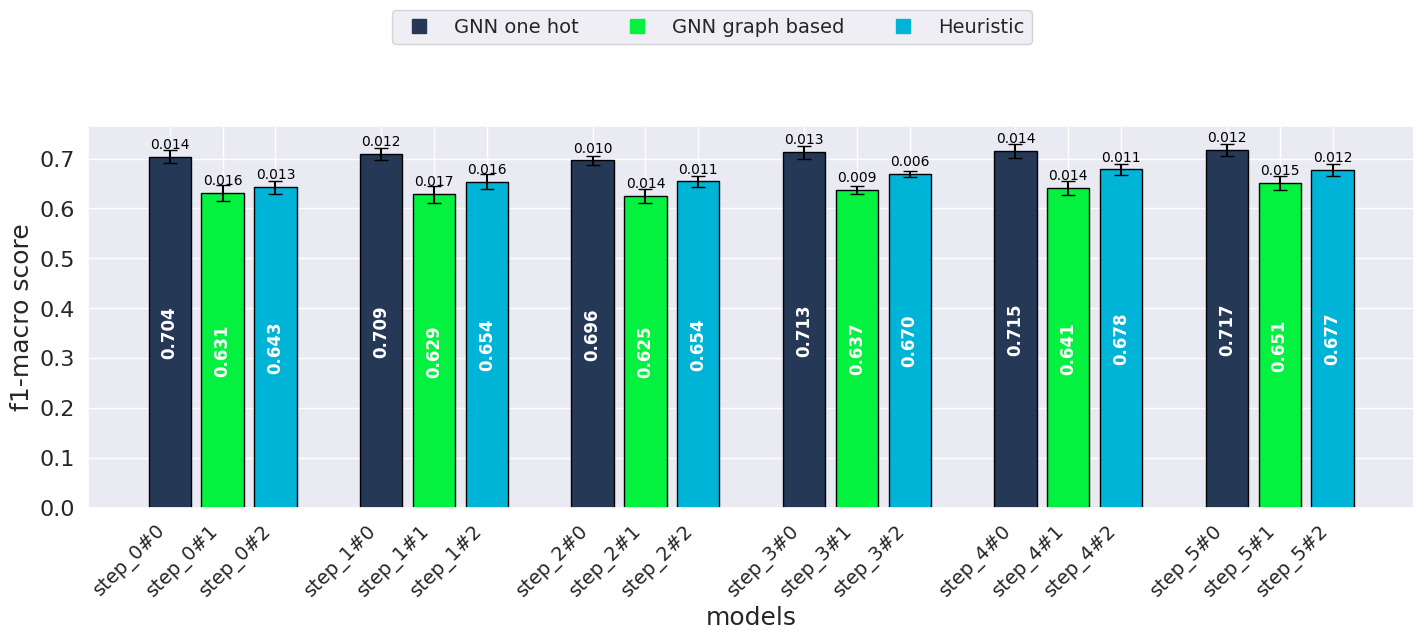

Mapping of real model names to short labels:
{'step_5_GL_TAGConv_3l_512h_w_k3_gnorm': 'step_5#1', 'step_5_MaxIbdSum': 'step_5#2', 'step_0_GL_TAGConv_3l_512h_w_k3_gnorm': 'step_0#1', 'step_0_MaxIbdSumPerClassSize': 'step_0#2', 'step_3_GL_TAGConv_3l_512h_w_k3_gnorm': 'step_3#1', 'step_3_MaxIbdSumPerClassSize': 'step_3#2', 'step_4_GL_TAGConv_3l_512h_w_k3_gnorm': 'step_4#1', 'step_4_MaxIbdSumPerClassSize': 'step_4#2', 'step_1_GL_TAGConv_3l_512h_w_k3_gnorm': 'step_1#1', 'step_1_MaxIbdSumPerClassSize': 'step_1#2', 'step_2_GL_TAGConv_3l_512h_w_k3_gnorm': 'step_2#1', 'step_2_MaxIbdSumPerClassSize': 'step_2#2'}


In [23]:
visualize_classifier_data_interpolation('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/genlink_simulated_real_data_class_balance_interpolation', fig_path='/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures')

## Fig.1

### Different loss functions

/tmp/ipykernel_2866614/4105648612.py:201: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2866614/4105648612.py:201: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2866614/4105648612.py:201: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2866614/4105648612.py:201: UserWarning: set_ticklabels() should only be used with a fixed n

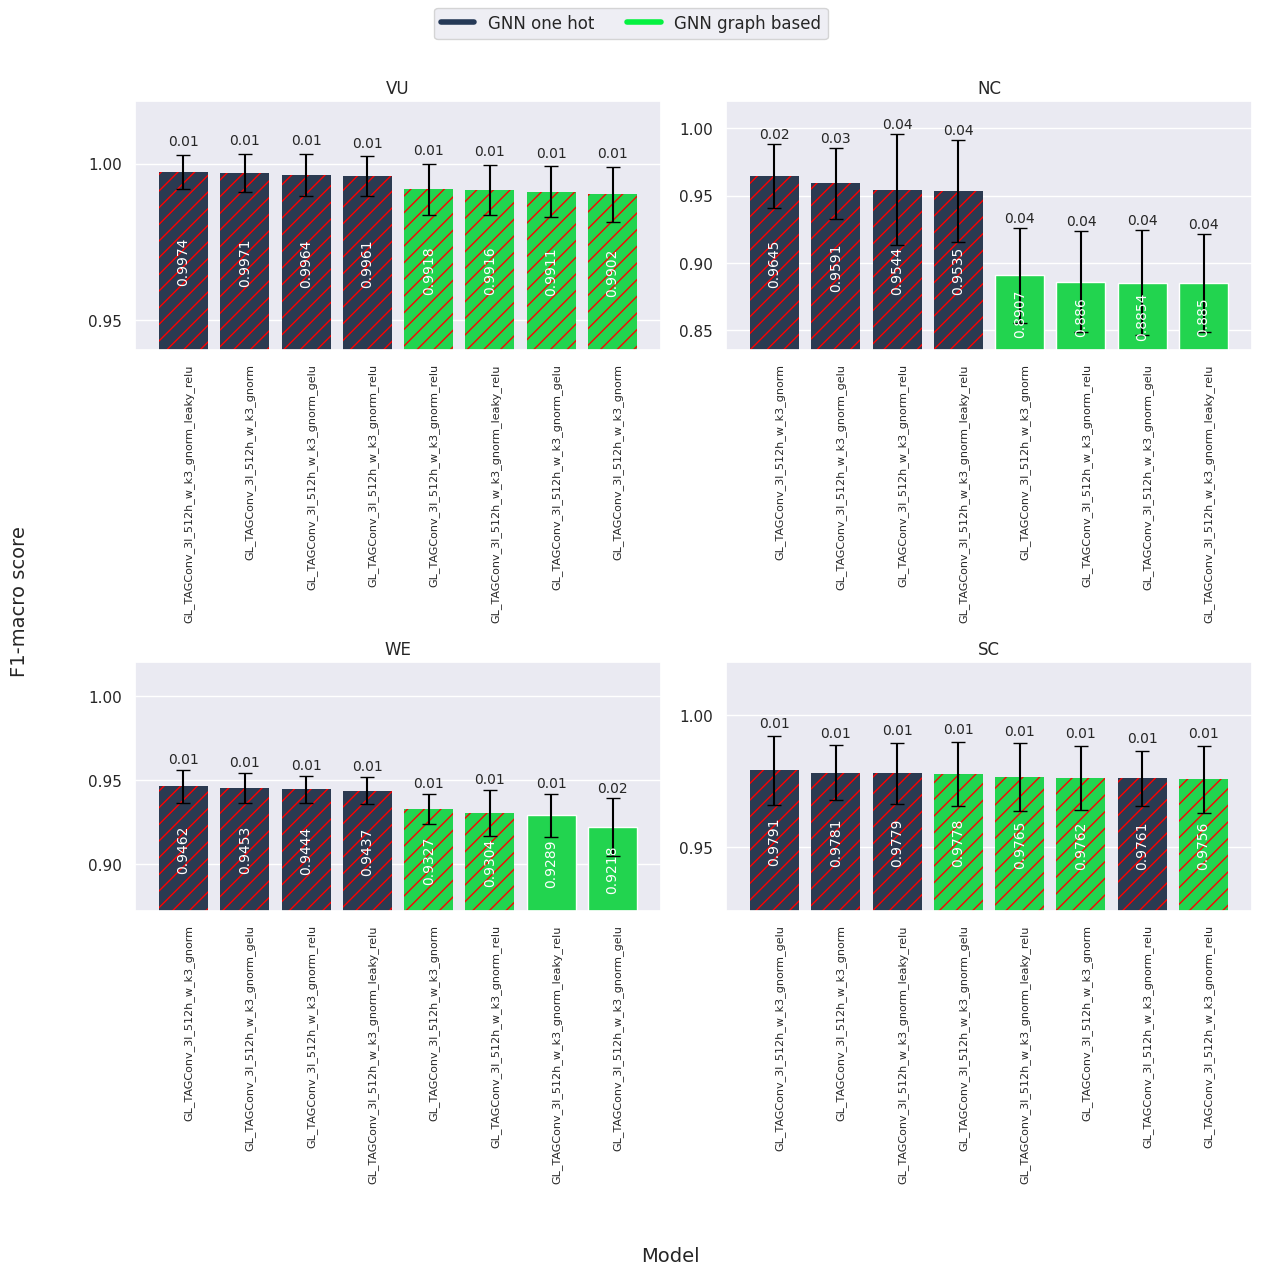

In [38]:
visualize_classifier_data_different_losses('/mnt/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_no_mask', sort_bars=True, annotate=True, mask_percent='no_different_losses', fig_path='/mnt/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)

### W/wo wdge weights

/tmp/ipykernel_2866614/3940369205.py:214: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2866614/3940369205.py:214: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2866614/3940369205.py:214: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2866614/3940369205.py:214: UserWarning: set_ticklabels() should only be used with a fixed n

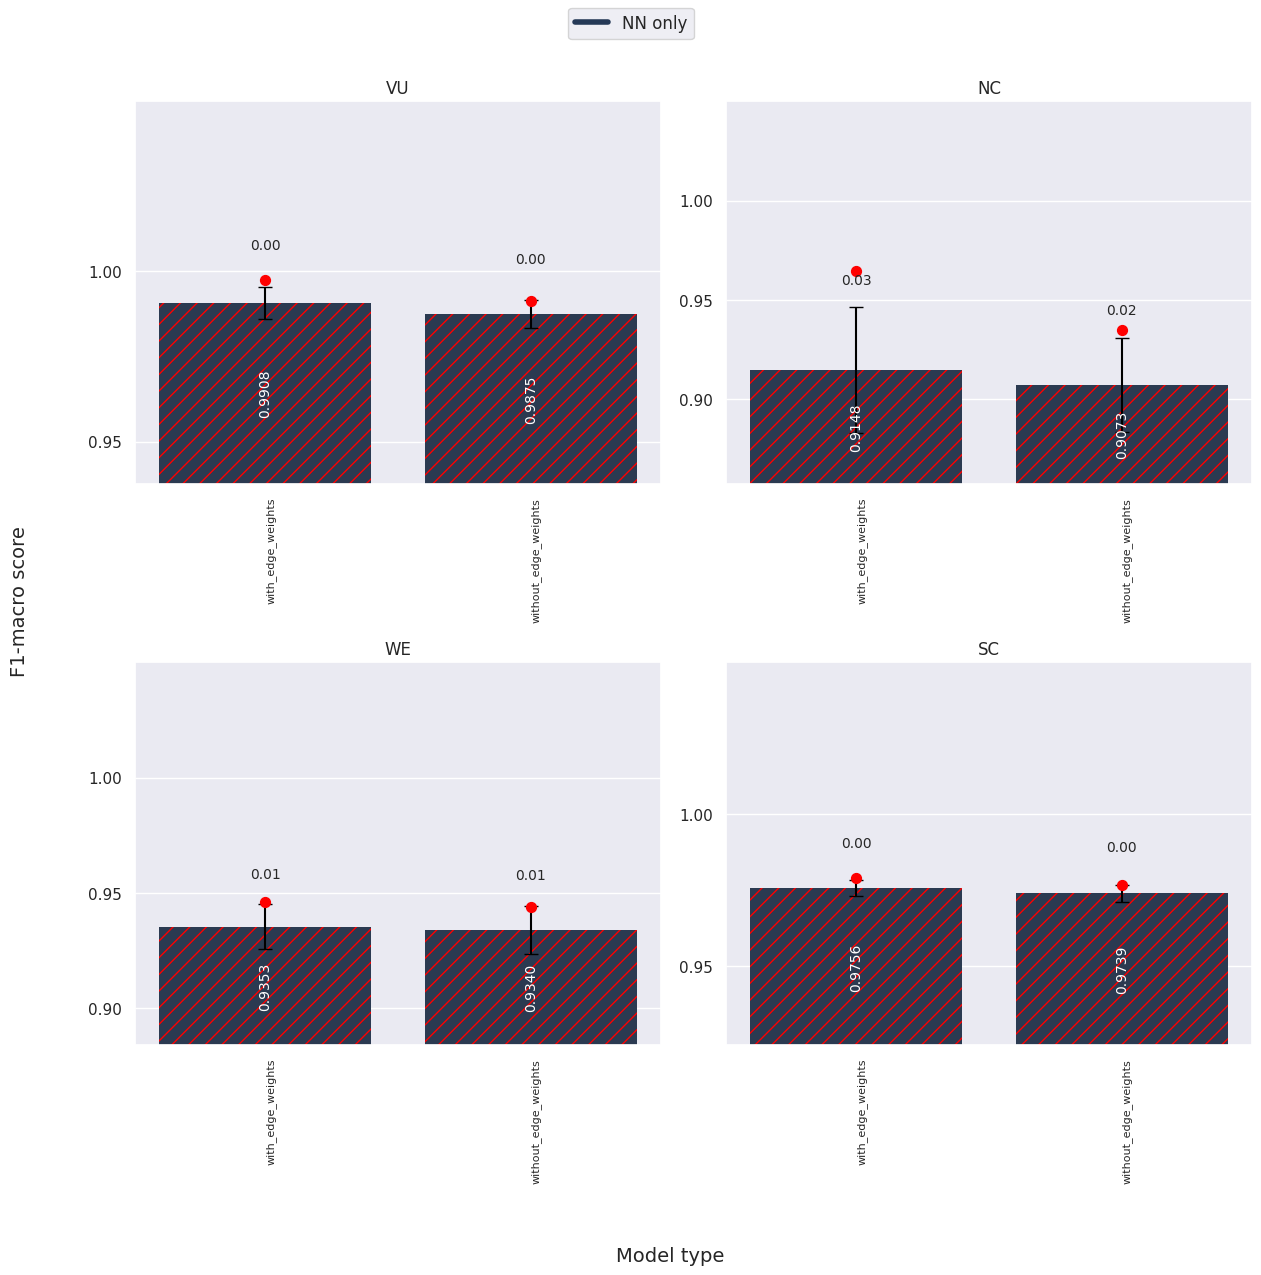

In [39]:
visualize_classifier_data_edge_weights('/mnt/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_no_mask', sort_bars=True, annotate=True, mask_percent='no_edge_weights', fig_path='/mnt/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)

### Nets configurations

/tmp/ipykernel_2866614/3375099966.py:215: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2866614/3375099966.py:215: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2866614/3375099966.py:215: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2866614/3375099966.py:215: UserWarning: set_ticklabels() should only be used with a fixed n

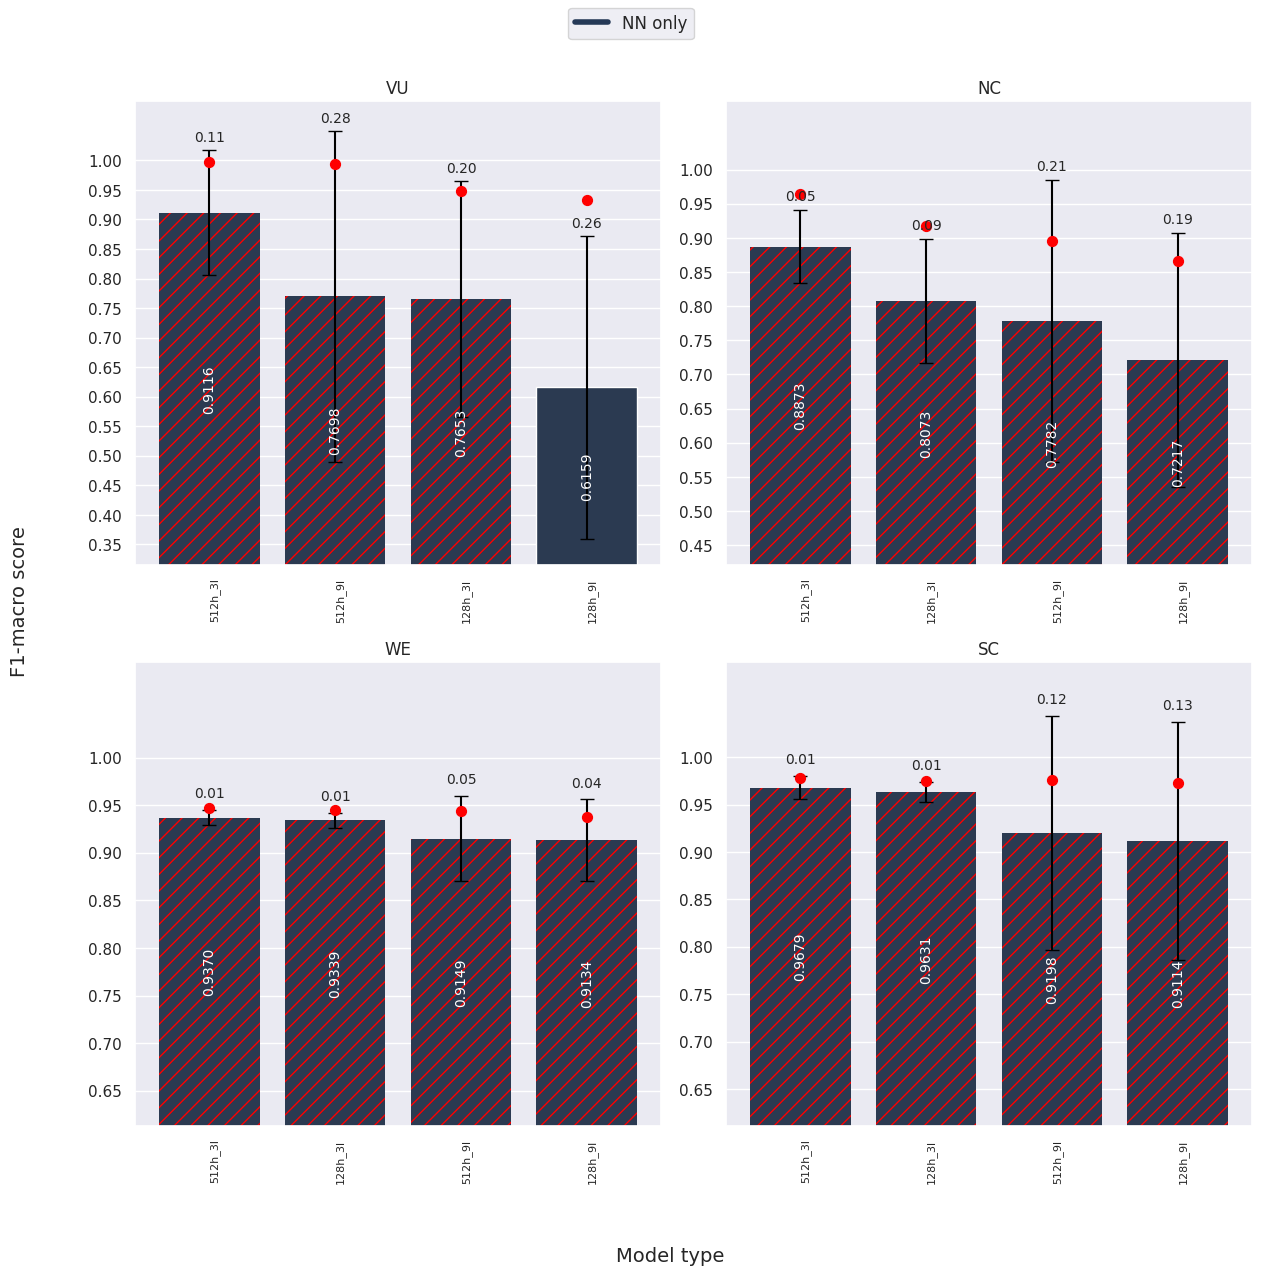

In [40]:
visualize_classifier_data_nets_configurations('/mnt/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_no_mask', sort_bars=True, annotate=True, mask_percent='no_net_configs', fig_path='/mnt/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)

### Masks, base scores

In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import ttest_ind
from os import listdir
from os.path import isdir, join

def visualize_classifier_data_all_masks(data_paths, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, dataset_plot_only=None, class_plot_only=None, highlight_best=False, plot_best_per_class=True):
    dataset_names = {'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Western-Europe':'WE', 'Scandinavia': 'SC', 'CR':'CR'}

    color_model_scheme = {'GNN one hot':'#253957', 'GNN graph based':'#05F140', 'MLP':'#FFB400', 'Heuristic':'#00B4D8', 'Community detection': '#EF233C'}

    sns.set_theme()
    # Set up a new 2x2 layout figure for combined plots
    fig, axs = plt.subplots(3, 2, figsize=(20, 15))
    ax_idx = 0
    all_handles, all_labels, all_pvalues = [], [], []

    for dataset_dir_idx, dataset_dir in enumerate(dataset_names.keys()):
        combined_data = []
        hue_names_combined = []
        ax = axs[ax_idx // 2, ax_idx % 2]

        for data_path_idx, data_path in enumerate(data_paths):
            all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
            all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
            if dataset_plot_only is not None:
                all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

            # Filtering the dataset directory
            if dataset_dir not in all_dataset_dirs:
                continue

            all_models_per_dataset_path = join(data_path, dataset_dir)
            all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]

            results = dict()
            for dir_path in all_dirs:
                if True:
                    with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                        curr_res = json.load(f)
                        if 'graph_based' in dir_path:
                            ft = 'graph_based'
                        elif 'one_hot' in dir_path:
                            ft = 'one_hot'
                        else:
                            ft = ''
                        if tuple([curr_res['model_name'], ft]) not in results.keys():
                            results[tuple([curr_res['model_name'], ft])] = []
                            if class_plot_only is None:
                                results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                            else:
                                results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])
                        else:
                            if class_plot_only is None:
                                results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                            else:
                                results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])

            classifiers = dict()
            for name_ft, metrics in results.items():
                name, ft = name_ft
                classifiers[tuple([name, ft])] = []
                classifiers[tuple([name, ft])].append(np.mean(metrics))
                classifiers[tuple([name, ft])].append(np.std(metrics))
                classifiers[tuple([name, ft])].append(metrics)

            classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
            
            for name_ft, metrics in classifiers.items():
                name, ft = name_ft
                all_fts.append(ft)
                classifier_names.append(name)
                means.append(metrics[0])
                std_devs.append(metrics[1])
                all_metrics.append(metrics[2])

            df = pd.DataFrame({
                'Classifier': classifier_names,
                'Mean': np.round(means, 4),
                'StdDev': std_devs,
                'feature_type': all_fts,
                'all_metrics': all_metrics,
                'Data_Path_Index': data_path_idx
            })

            if sort_bars:
                df = df.sort_values('Mean', ascending=False)

            df = df.reset_index(drop=True)

            # Assign color and hue names
            cols, hue_names = [], []
            for index, row in df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristic'])
                    hue_names.append('Heuristic')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    hue_names.append('GNN one hot')

            # Select one best model per class for each dataframe before combining
            one_best_model_per_class_df = []
            one_best_model_hue_names = []
            for u_n in np.unique(hue_names):
                current_df = df.loc[np.array(hue_names) == u_n]
                best_model = current_df.loc[[current_df['Mean'].idxmax()]]
                one_best_model_per_class_df.append(best_model)
                one_best_model_hue_names.append(u_n)

            one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)
            df = one_best_model_per_class_df

            if sort_bars:
                df = df.sort_values(by=['Mean'], ascending=[False])

            tmp_pvalues = []
            for i in range(df.shape[0]):
                if i == 0:
                    tmp_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(df.iloc[0, 4], df.iloc[i, 4], equal_var=False)
                    tmp_pvalues.append(p_value)

            # n_tests = len(all_pvalues)
            # print(all_pvalues)
            # all_pvalues += [p * 4 for p in tmp_pvalues]
            df['all_pvalues'] = [p * 4 for p in tmp_pvalues]

            combined_data.append(df)
            hue_names_combined += one_best_model_hue_names

        combined_data_df = pd.concat(combined_data)
        combined_data_df = combined_data_df.reset_index(drop=True)

        if plot_best_per_class:
            # Optionally sort the bars by their mean values
            if sort_bars:
                combined_data_df = combined_data_df.sort_values(by=['Data_Path_Index', 'Mean'], ascending=[True, False])

            combined_data_df = combined_data_df.reset_index(drop=True)

            # all_pvalues = []
            # for i in range(combined_data_df.shape[0]):
            #     if i == 0:
            #         all_pvalues.append(1)
            #     else:
            #         statistic, p_value = ttest_ind(combined_data_df.iloc[0, 4], combined_data_df.iloc[i, 4], equal_var=False)
            #         all_pvalues.append(p_value)

            # n_tests = len(all_pvalues)
            # all_pvalues = [p * n_tests for p in all_pvalues]

            one_best_model_per_class_hue_names = []
            cols = []
            for index, row in combined_data_df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristic'])
                    one_best_model_per_class_hue_names.append('Heuristic')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    one_best_model_per_class_hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')


        # print(combined_data_df)
        # Draw the bars using Matplotlib
        x_positions = combined_data_df.index + np.array([i // 4 for i in range(len(combined_data_df.index))]) / 2
        bars = ax.bar(x_positions, combined_data_df['Mean'], yerr=combined_data_df['StdDev'], color=cols, capsize=5, error_kw={'elinewidth': 1, 'ecolor': 'black'})
        # Create a list of bars with their center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]
        # print(len(bars_with_x))

        # Sort the bars based on their x-position
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])
        # print(sorted_bars_with_x)
        # print(np.round(combined_data_df['all_pvalues'].to_numpy(), 2))

        # Extract the sorted bars
        # print(combined_data_df)
        sorted_bars = [bar for bar, x in sorted_bars_with_x]
        for i, bar in enumerate(sorted_bars):
            if combined_data_df['all_pvalues'].to_numpy()[i] > 0.05:
                bar.set_hatch('//')
                bar.set_edgecolor('red')
                bar.set_linewidth(0)
            # else:
            #     print(all_pvalues[i])

        ax.set_yticks([i * 0.05 for i in range(21)])
        # Set y-axis limits
        # Set y-axis limits with a bit of extra space to prevent label cropping
        ax.set_ylim(np.min(combined_data_df['Mean']) - 0.1, 1.05)

        # Add bar labels after setting limits
        for bar in bars:
            height = bar.get_height()
            label_position = (height - np.min(combined_data_df['Mean'] + 0.1)) / 2  # Place label slightly above the bar to prevent cropping
            ax.text(bar.get_x() + bar.get_width() / 2, np.min(combined_data_df['Mean']) + label_position, f'{height:.4f}',
                    ha='center', va='center', rotation=90, color='white', fontsize=10)

        # Optionally annotate standard deviation above bars
        if annotate:
            for i, (mean, std) in enumerate(zip(combined_data_df['Mean'], combined_data_df['StdDev'])):
                ax.text(x_positions[i], mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=10)
        
        # Set x-axis labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels([name + f' ({i // 4 * 25}%)' for i, name in enumerate(combined_data_df['Classifier'])], rotation=90, ha='right', rotation_mode='anchor', fontsize=8)

        flag = True
        for i in range(len(ax.get_xticklabels())):
            # print(ax.get_xticklabels()[i].get_text())
            if i % 4 == 0:
                flag = True
            if ax.get_xticklabels()[i].get_text().split(' ')[0] in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                flag = False
            elif flag:
                plt.setp(ax.get_xticklabels()[i], color='red', weight='bold')

        # Set title, labels, and other properties
        ax.set_title(f'{dataset_names[dataset_dir]}', fontsize=20)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Collect legend handles and labels from the current color scheme
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        ax_idx += 1

    # Remove duplicate handles and labels by creating a unique set
    unique_handles_labels = dict(zip(all_labels, all_handles))
    del unique_handles_labels['Community detection']
    # print(unique_handles_labels)
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', ncol=4, fontsize='medium')
    # Add common X and Y labels
    fig.text(0.5, -0.05, 'Model', ha='center', fontsize=20)
    fig.text(-0.05, 0.5, 'F1-macro score', va='center', rotation='vertical', fontsize=20)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_all_masks.pdf', bbox_inches="tight")
    plt.show()


/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/disk/10tb/home/shm

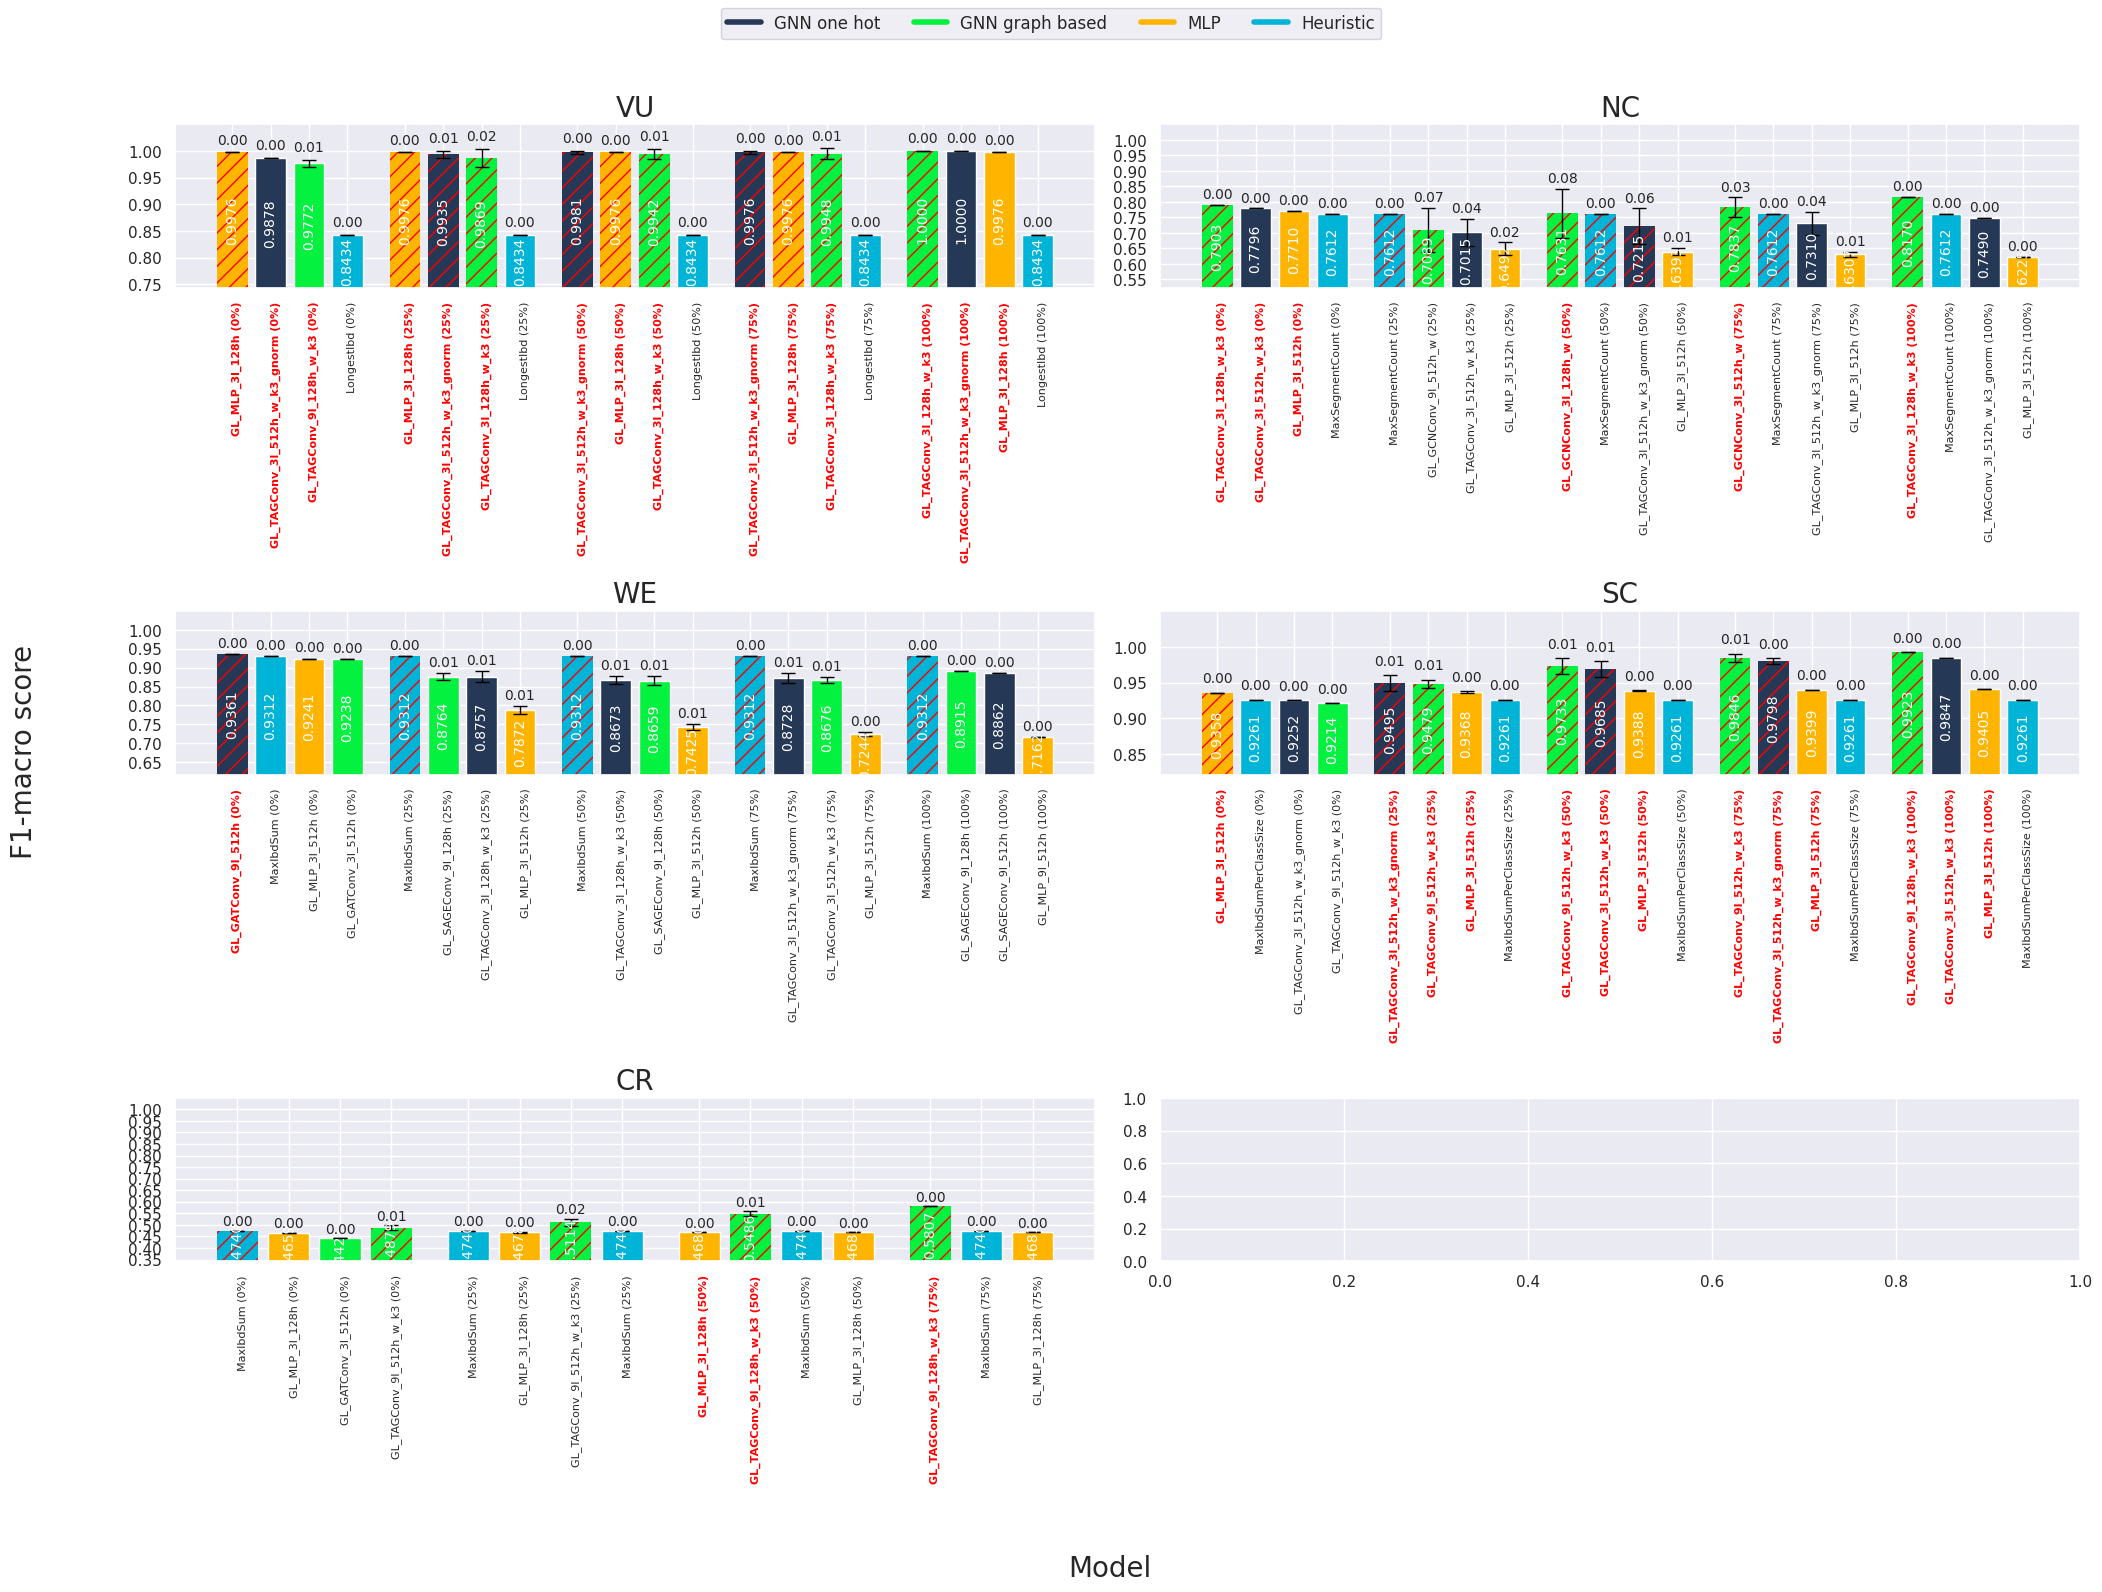

In [5]:
visualize_classifier_data_all_masks(['/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_0',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_25',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_50',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_75',
                                     '/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_100'], sort_bars=True, annotate=True, mask_percent='all', fig_path='/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)

### No masks, base scores

In [114]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from os import listdir
from os.path import isdir, join
import matplotlib.gridspec as gridspec

def visualize_classifier_data(data_path, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, 
                              dataset_plot_only=None, class_plot_only=None, highlight_best=False, 
                              plot_best_per_class=True):   
    dataset_names = {'Western-Europe':'WE', 'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Scandinavia': 'SC', 'CR':'CR'}

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
    all_dataset_dirs_mask = [True if d in dataset_names.keys() else False for d in all_dataset_dirs]
    all_dataset_dirs = (np.array(all_dataset_dirs)[all_dataset_dirs_mask]).tolist()
    print("Datasets:", all_dataset_dirs)
    if dataset_plot_only is not None:
        all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

    # --------------------------
    # First plot: Dataset stats
    # --------------------------
    all_dataset_stats = [f for f in listdir(join(data_path, 'dataset_stats')) if isdir(join(join(data_path, 'dataset_stats'), f))]
    results = dict()
    for dataset_dir in all_dataset_stats:
        all_splits_per_dataset_path = join(join(data_path, 'dataset_stats'), dataset_dir)
        all_dirs = [f for f in listdir(all_splits_per_dataset_path) if isdir(join(all_splits_per_dataset_path, f))]
        for dir_path in all_dirs:
            with open(join(join(join(data_path, 'dataset_stats'), dataset_dir), dir_path+'/stats.json'), 'r') as f:
                curr_stat = json.load(f)
                results.setdefault(dataset_dir, []).append(curr_stat['number_connected_components'])

    stats_dataset_name, stats_dataset_mean, stats_dataset_std = [], [], []
    for dataset_name, stats in results.items():
        stats_dataset_name.append(dataset_name)
        stats_dataset_mean.append(np.mean(stats))
        stats_dataset_std.append(np.std(stats))

    df = pd.DataFrame({
            'Dataset': [(dataset_names[name] + f' ({np.round(stats_dataset_mean[i], 1)})') for i, name in enumerate(stats_dataset_name)],
            'Number of components': np.round(stats_dataset_mean, 4),
            'std': stats_dataset_std
        })

    sns.set_theme()
    stats_bar_plot = sns.barplot(x='Dataset', y='Number of components', data=df, color='#05F140')
    for i, (mean, std) in enumerate(zip(df['Number of components'], df['std'])):
        stats_bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)
        if annotate:
            stats_bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=14)

    plt.xlabel('dataset', fontsize=20)
    plt.ylabel('number of components', fontsize=20)
    plt.xticks(rotation=90, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'{fig_path}/train_connected_components_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()

    # ---------------------------------------------------
    # Combined model performance: 5 subfigures arranged
    # with 2x2 grid for the first 4 and the 5th centered.
    # ---------------------------------------------------
    # Create a gridspec: first 2 rows (2 columns each) and a third row spanning both columns.
    fig = plt.figure(figsize=(10, 18))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, :])
    axes_list = [ax1, ax2, ax3, ax4, ax5]

    # Lists to accumulate original x-tick (classifier) labels across subfigures
    global_classifier_labels = []  # will hold all classifier names (may contain duplicates)
    subfig_xtick_info = []         # list of tuples: (axis, list of classifier names for that subplot)
    
    all_handles, all_labels = [], []
    # Loop over each dataset directory and use one axis per dataset
    for ax, dataset_dir in zip(axes_list, all_dataset_dirs):
        all_models_per_dataset_path = join(data_path, dataset_dir)
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]

        results_dict = dict()
        for dir_path in all_dirs:
            with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                curr_res = json.load(f)
                if 'graph_based' in dir_path:
                    ft = 'graph_based'
                elif 'one_hot' in dir_path:
                    ft = 'one_hot'
                else:
                    ft = ''
                key = (curr_res['model_name'], ft)
                if key not in results_dict:
                    results_dict[key] = []
                if class_plot_only is None:
                    results_dict[key].append(curr_res['f1_macro'])
                else:
                    results_dict[key].append(curr_res['class_scores'][class_plot_only])

        classifiers = dict()
        for name_ft, metrics in results_dict.items():
            name, ft = name_ft
            mean_val = np.mean(metrics)
            std_val = np.std(metrics)
            classifiers[name_ft] = [mean_val, std_val, metrics]

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        for name_ft, stats in classifiers.items():
            name, ft = name_ft
            classifier_names.append(name)
            means.append(stats[0])
            std_devs.append(stats[1])
            all_fts.append(ft)
            all_metrics.append(stats[2])
        
        df_classifier = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        if sort_bars:
            df_classifier = df_classifier.sort_values('Mean', ascending=False)
        df_classifier = df_classifier.reset_index(drop=True)

        cols, hue_names = [], []
        color_model_scheme = {'GNN one hot':'#253957', 'GNN graph based':'#05F140', 
                              'MLP':'#FFB400', 'Heuristic':'#00B4D8', 'Community detection': '#EF233C'}
        for index, row in df_classifier.iterrows():
            model_name = row['Classifier']
            ft = row['feature_type']
            if 'MLP' in model_name:
                cols.append(color_model_scheme['MLP'])
                hue_names.append('MLP')
            elif ft == 'graph_based':
                cols.append(color_model_scheme['GNN graph based'])
                hue_names.append('GNN graph based')
            elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                cols.append(color_model_scheme['Heuristic'])
                hue_names.append('Heuristic')
            elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 
                                'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                cols.append(color_model_scheme['Community detection'])
                hue_names.append('Community detection')
            else:
                cols.append(color_model_scheme['GNN one hot'])
                hue_names.append('GNN one hot')

        one_best_model_per_class_df = []
        one_best_model_hue_names = []
        for u_n in np.unique(hue_names):
            current_df = df_classifier.loc[np.array(hue_names) == u_n]
            best_model = current_df.loc[[current_df['Mean'].idxmax()]]
            one_best_model_per_class_df.append(best_model)
            one_best_model_hue_names.append(u_n)
        one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
        if plot_best_per_class:
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)
            # (Repeated sort/reset if needed removed for brevity)

            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(one_best_model_per_class_df.iloc[0, 4], 
                                                     one_best_model_per_class_df.iloc[i, 4], equal_var=False)
                    all_pvalues.append(p_value)
            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]

            one_best_model_per_class_hue_names = []
            for index, row in one_best_model_per_class_df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 
                                    'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristic'])
                    one_best_model_per_class_hue_names.append('Heuristic')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 
                                    'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    one_best_model_per_class_hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')

        # Create the bar plot on the current axis
        bar_plot = sns.barplot(x=one_best_model_per_class_df.index, 
                               y=one_best_model_per_class_df.Mean, 
                               data=one_best_model_per_class_df, 
                               palette=color_model_scheme, 
                               hue=one_best_model_per_class_hue_names, 
                               ax=ax, legend=None)
        
        # (Apply error bars, hatching, bar labels, etc.)
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])
        sorted_bars = [bar for bar, x in sorted_bars_with_x]
        for i, bar in enumerate(sorted_bars):
            if i < len(all_pvalues) and all_pvalues[i] > 0.05:
                bar.set_hatch('//')
                bar.set_edgecolor('red')
                bar.set_linewidth(0)
        for container in bar_plot.containers:
            bar_plot.bar_label(container, label_type='center', rotation=90, color='white', fontsize=18)
        for i, (mean, std) in enumerate(zip(one_best_model_per_class_df['Mean'], one_best_model_per_class_df['StdDev'])):
            ax.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)
            if annotate:
                ax.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=14)

        ax.set_title(f'{dataset_names[dataset_dir]}', fontsize=30)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # (Optional: set color for specific x tick labels if desired)
        for tick in ax.get_xticklabels():
            if tick.get_text() not in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 
                                        'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                tick.set_color('black')
                # tick.set_weight('bold')

        ax.set_yticks([i * 0.1 for i in range(11)])
        ax.set_yticklabels(np.round([i * 0.1 for i in range(11)], 2), fontsize=18)
        ax.set_ylim(np.min(one_best_model_per_class_df['Mean']) - 0.15, 1.05)

        # Store the original classifier names for this subplot and accumulate globally
        orig_labels = one_best_model_per_class_df['Classifier'].tolist()
        global_classifier_labels.extend(orig_labels)
        subfig_xtick_info.append((ax, orig_labels))
        
        # Collect legend handles and labels from the current color scheme
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)
    
    # After processing all subfigures, compute unique classifier names and build an encoding mapping.
    # We preserve order of first occurrence.
    unique_classifiers = list(dict.fromkeys(global_classifier_labels))
    mapping = { classifier: f"#{i}" for i, classifier in enumerate(unique_classifiers) }
    # Also build a reverse mapping: encoded label -> real classifier
    mapping_encoded_to_real = { f"#{i}": classifier for i, classifier in enumerate(unique_classifiers) }
    print("Mapping of new labels to real classifier names:")
    print(mapping_encoded_to_real)
    
    # Now update each subplot's x-tick labels with the encoded labels.
    for ax, orig_labels in subfig_xtick_info:
        new_labels = [mapping[label] for label in orig_labels]
        ax.set_xticklabels(new_labels, rotation=0, fontsize=16)
    
    # Remove duplicate handles and labels for legend
    unique_handles_labels = dict(zip(all_labels, all_handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', ncol=5, fontsize='medium')
    fig.text(0.5, -0.05, 'model', ha='center', fontsize=24)
    fig.text(-0.05, 0.5, 'f1-macro score', va='center', rotation='vertical', fontsize=24)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()


Datasets: ['Scandinavia', 'Western-Europe', 'NC_graph_rel_eng', 'CR', 'Volga']


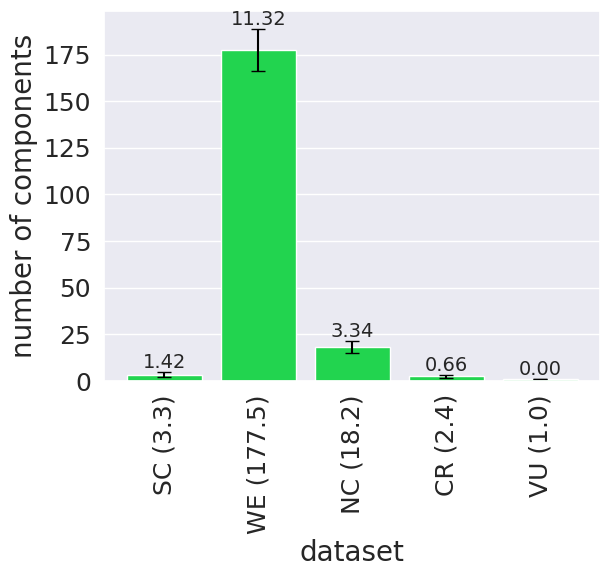

Mapping of new labels to real classifier names:
{'#0': 'GL_TAGConv_3l_512h_w_k3_gnorm_gelu', '#1': 'GL_TAGConv_9l_512h_w_k3', '#2': 'GL_MLP_3l_512h', '#3': 'MaxIbdSumPerClassSize', '#4': 'LabelPropagation', '#5': 'GL_TAGConv_3l_512h_w_k3', '#6': 'MaxIbdSum', '#7': 'GL_GATConv_3l_512h', '#8': 'GL_MLP_9l_512h', '#9': 'GL_TAGConv_3l_512h_w_k3_gnorm', '#10': 'GL_SAGEConv_9l_512h', '#11': 'GL_TAGConv_3l_512h_w_k3_gnorm_relu', '#12': 'GL_TAGConv_9l_128h_w_k3', '#13': 'GL_TAGConv_3l_512h_w_k3_gnorm_leaky_relu', '#14': 'GL_MLP_3l_128h', '#15': 'LongestIbd'}


/tmp/ipykernel_1892139/3211627299.py:270: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=0, fontsize=16)
/tmp/ipykernel_1892139/3211627299.py:270: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=0, fontsize=16)
/tmp/ipykernel_1892139/3211627299.py:270: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=0, fontsize=16)
/tmp/ipykernel_1892139/3211627299.py:270: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=0, fontsize=16)
/tmp/ipykernel_1892139/3211627299.py:270: UserWarning: set_ticklabels() should only be u

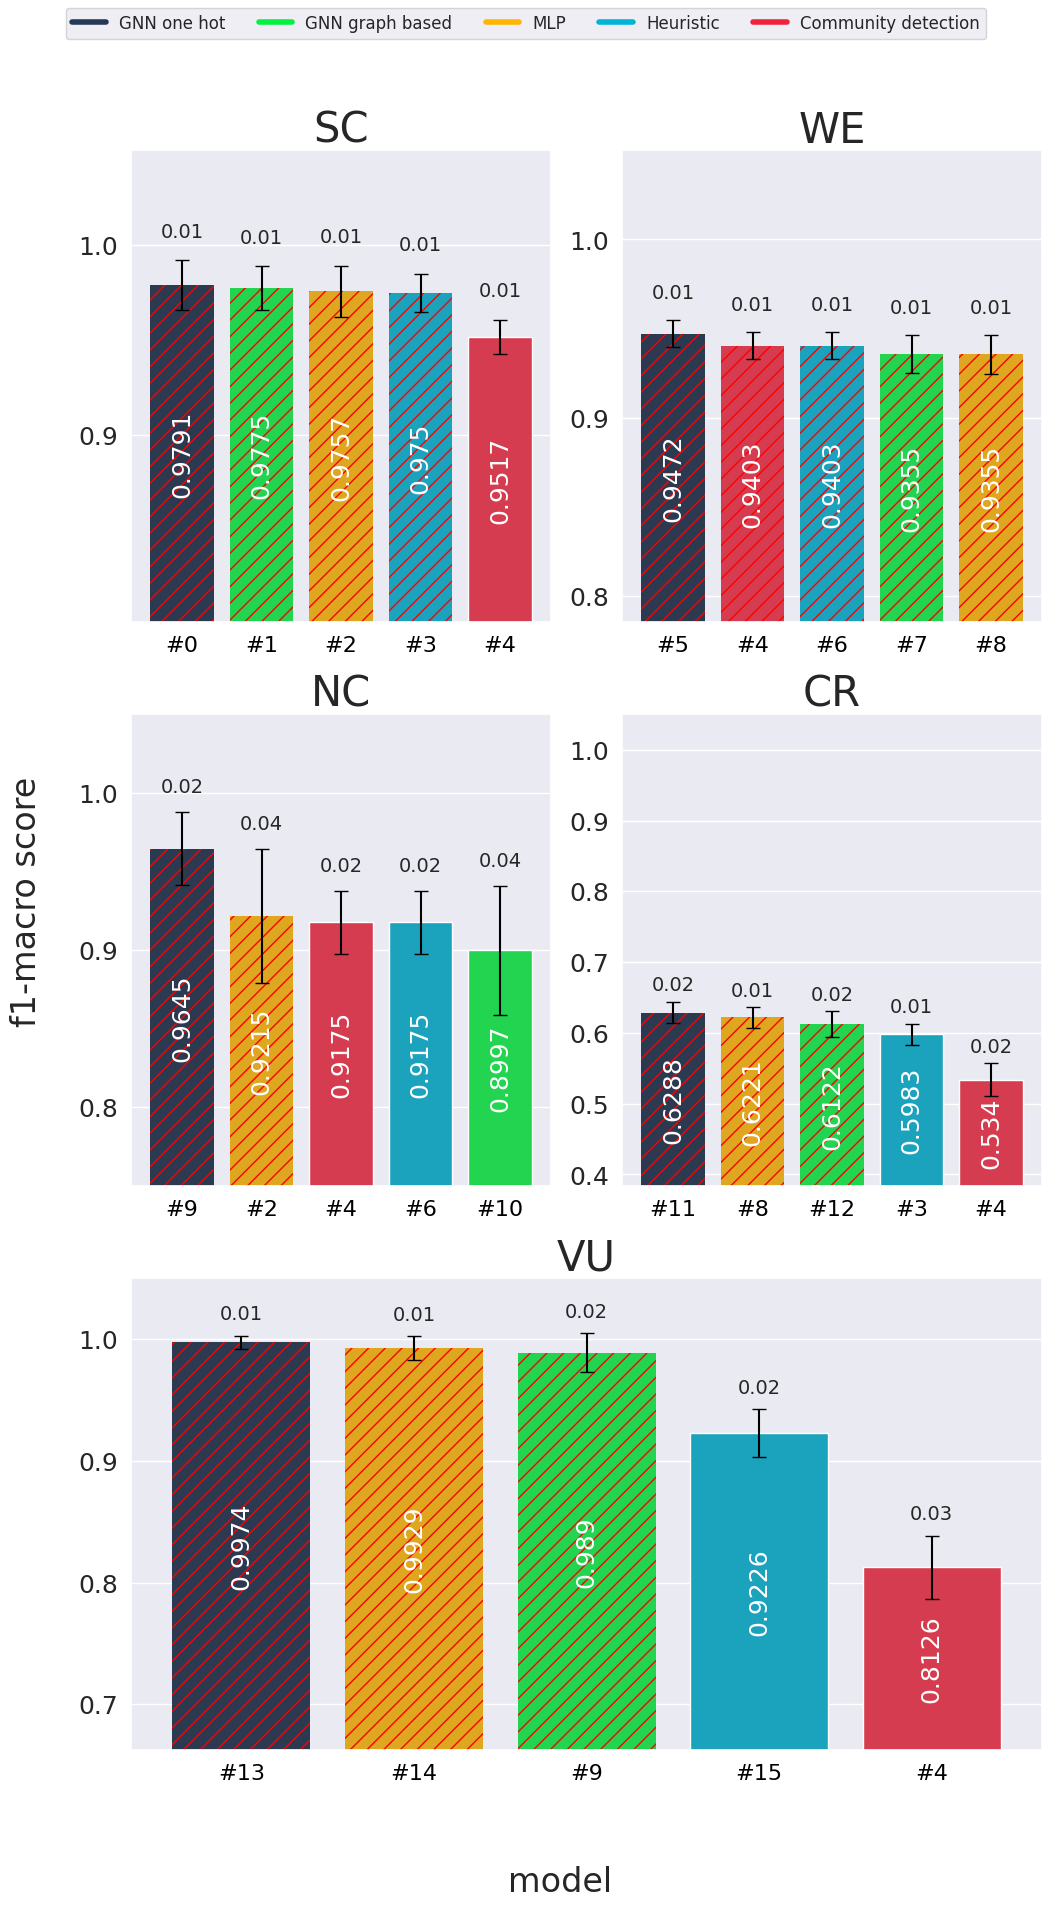

In [115]:
visualize_classifier_data('/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_no_mask', sort_bars=True, annotate=True, mask_percent='no', fig_path='/disk/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)

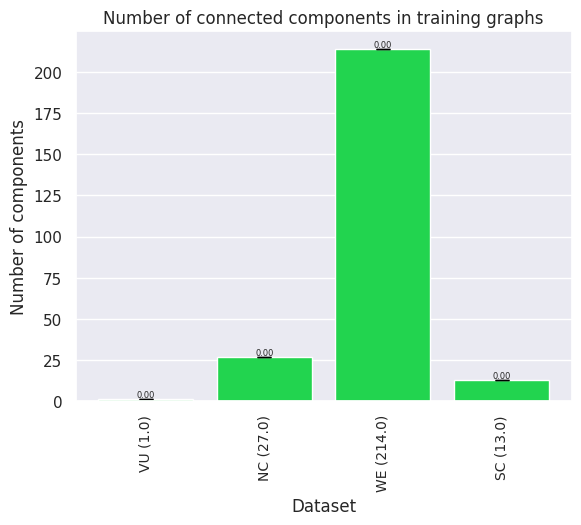

/mnt/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipykernel_2866614/3029286240.py:241: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/mnt/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipykernel_2866614/3029286240.py:241: UserWarn

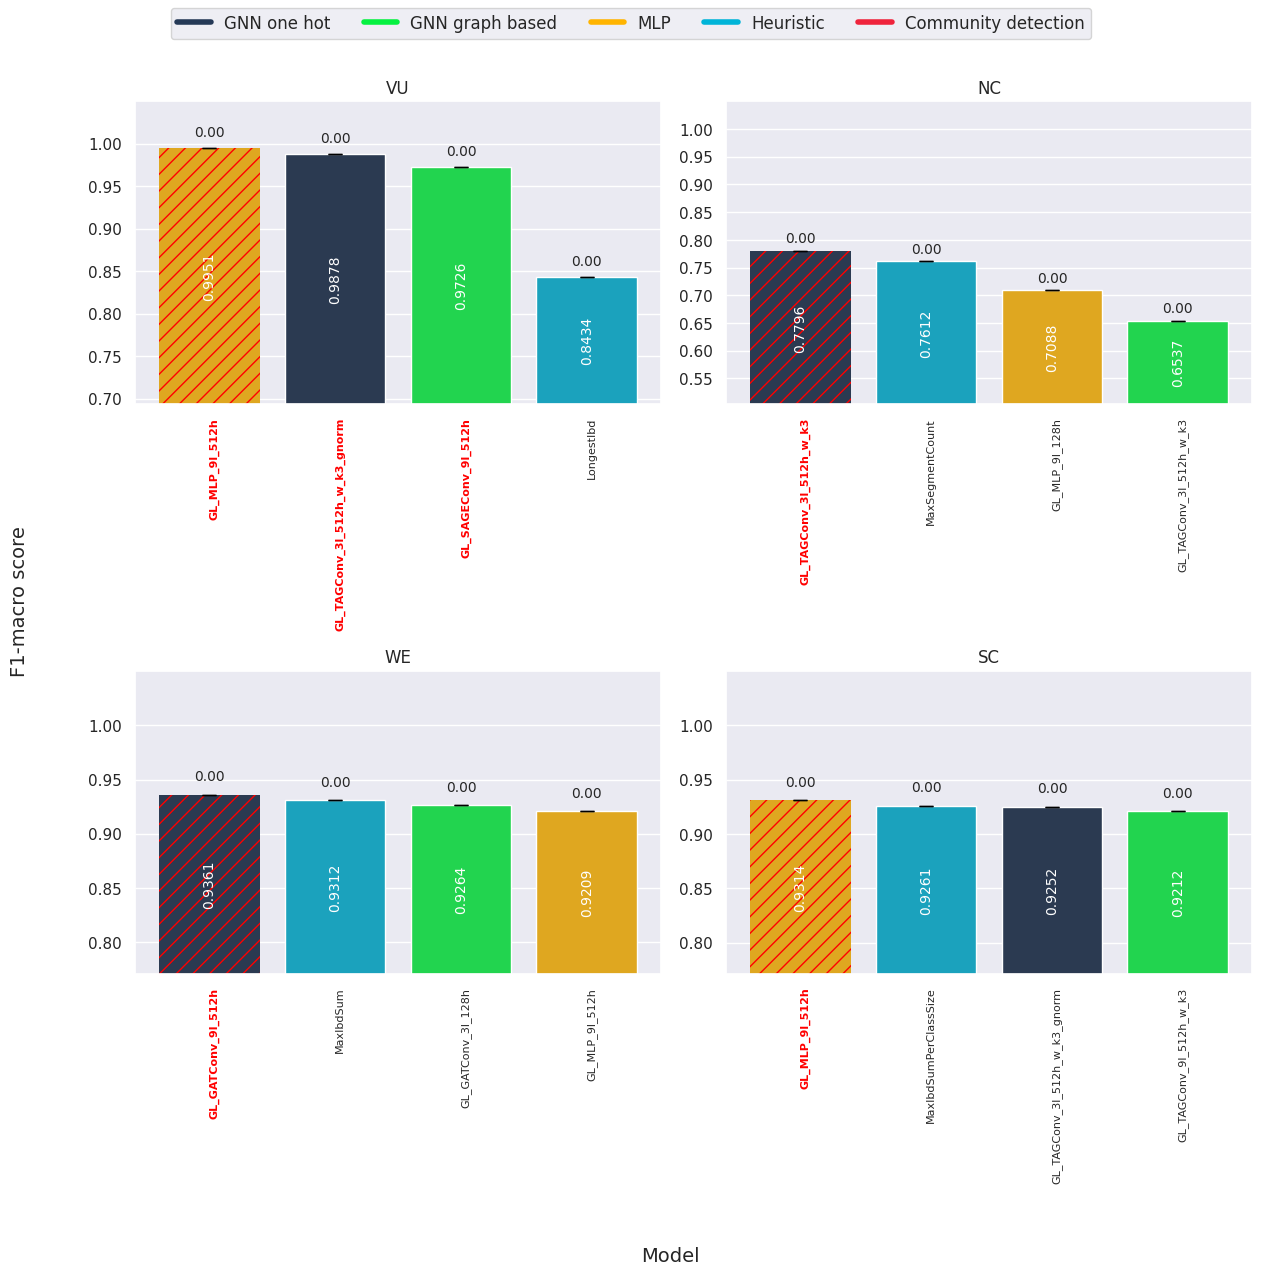

In [43]:
visualize_classifier_data('/mnt/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_0', sort_bars=True, annotate=True, mask_percent='0', fig_path='/mnt/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)

# Distribution figs

In [1]:
import sys
import os
import torch
import pickle
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), os.path.pardir)))
from utils.genlink import DataProcessor, NullSimulator, Trainer

In [2]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/Western-Europe.csv')

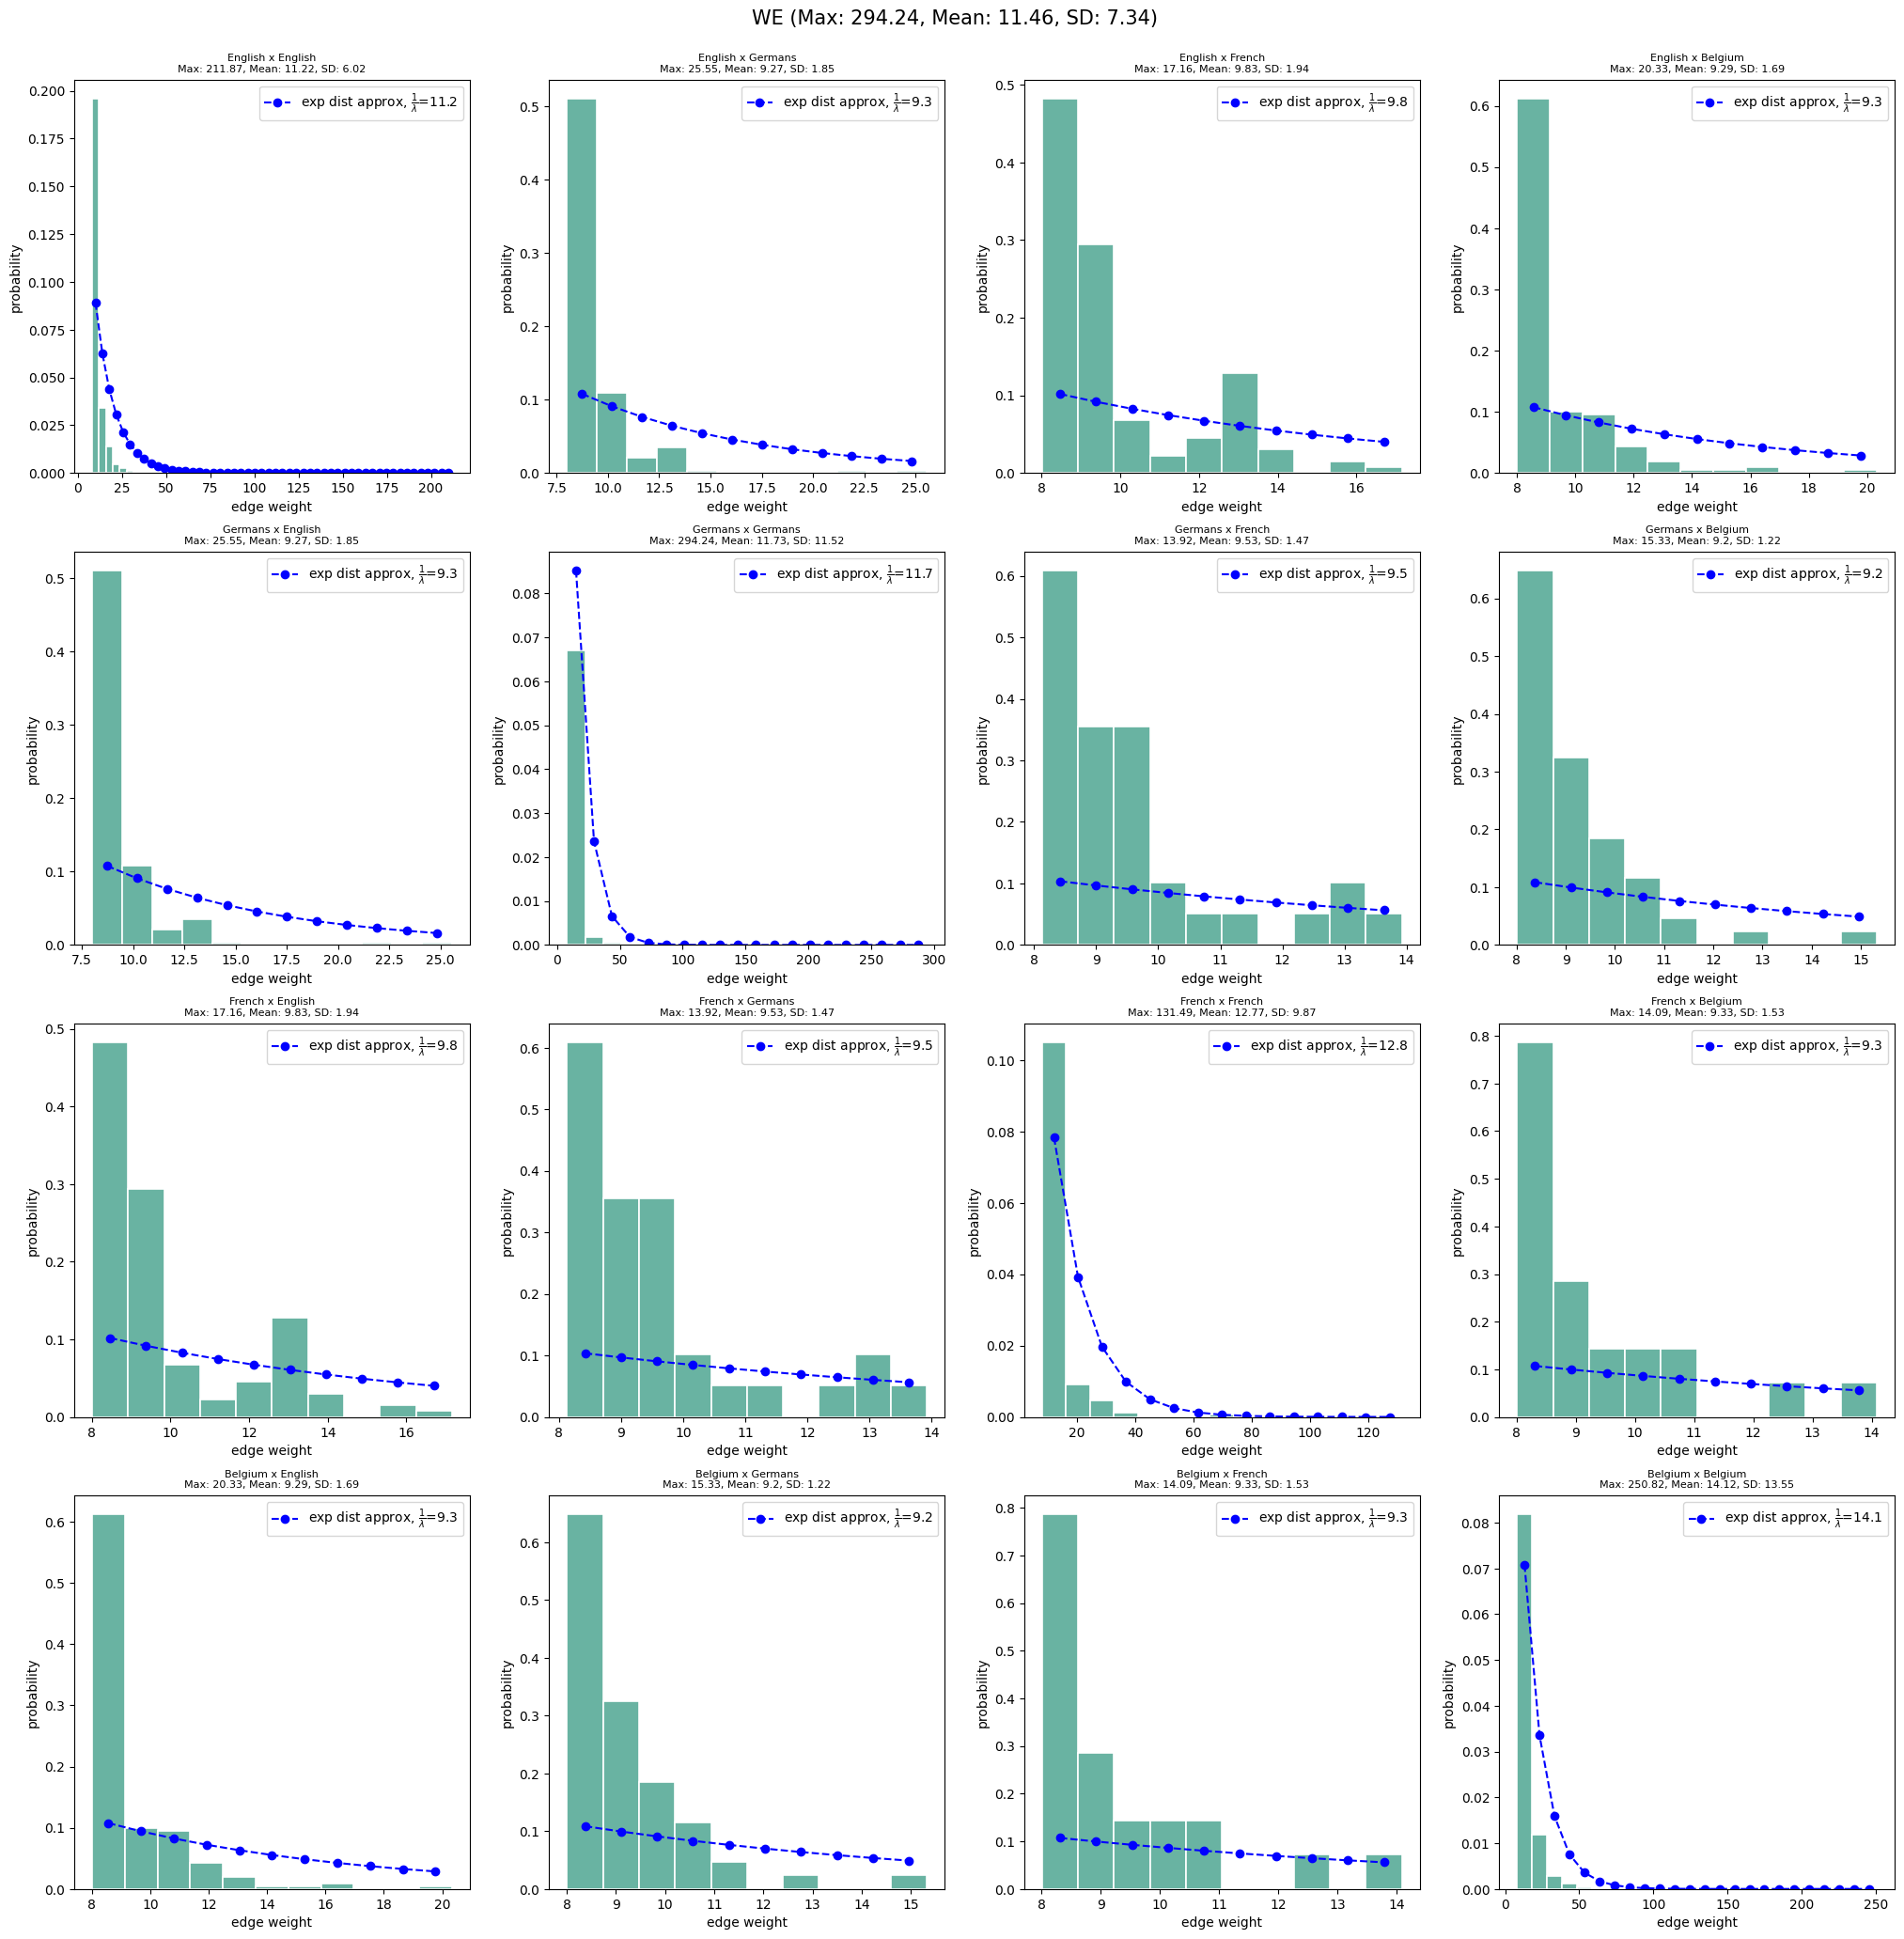

In [3]:
dp.plot_edge_weight_distribution(fig_size=(25, 25), dataset_name='WE', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/WE_dataset_weight_dist.pdf',
                                 title_pos=0.91, title_font_size=15)

In [4]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/NC_graph_rel_eng.csv')

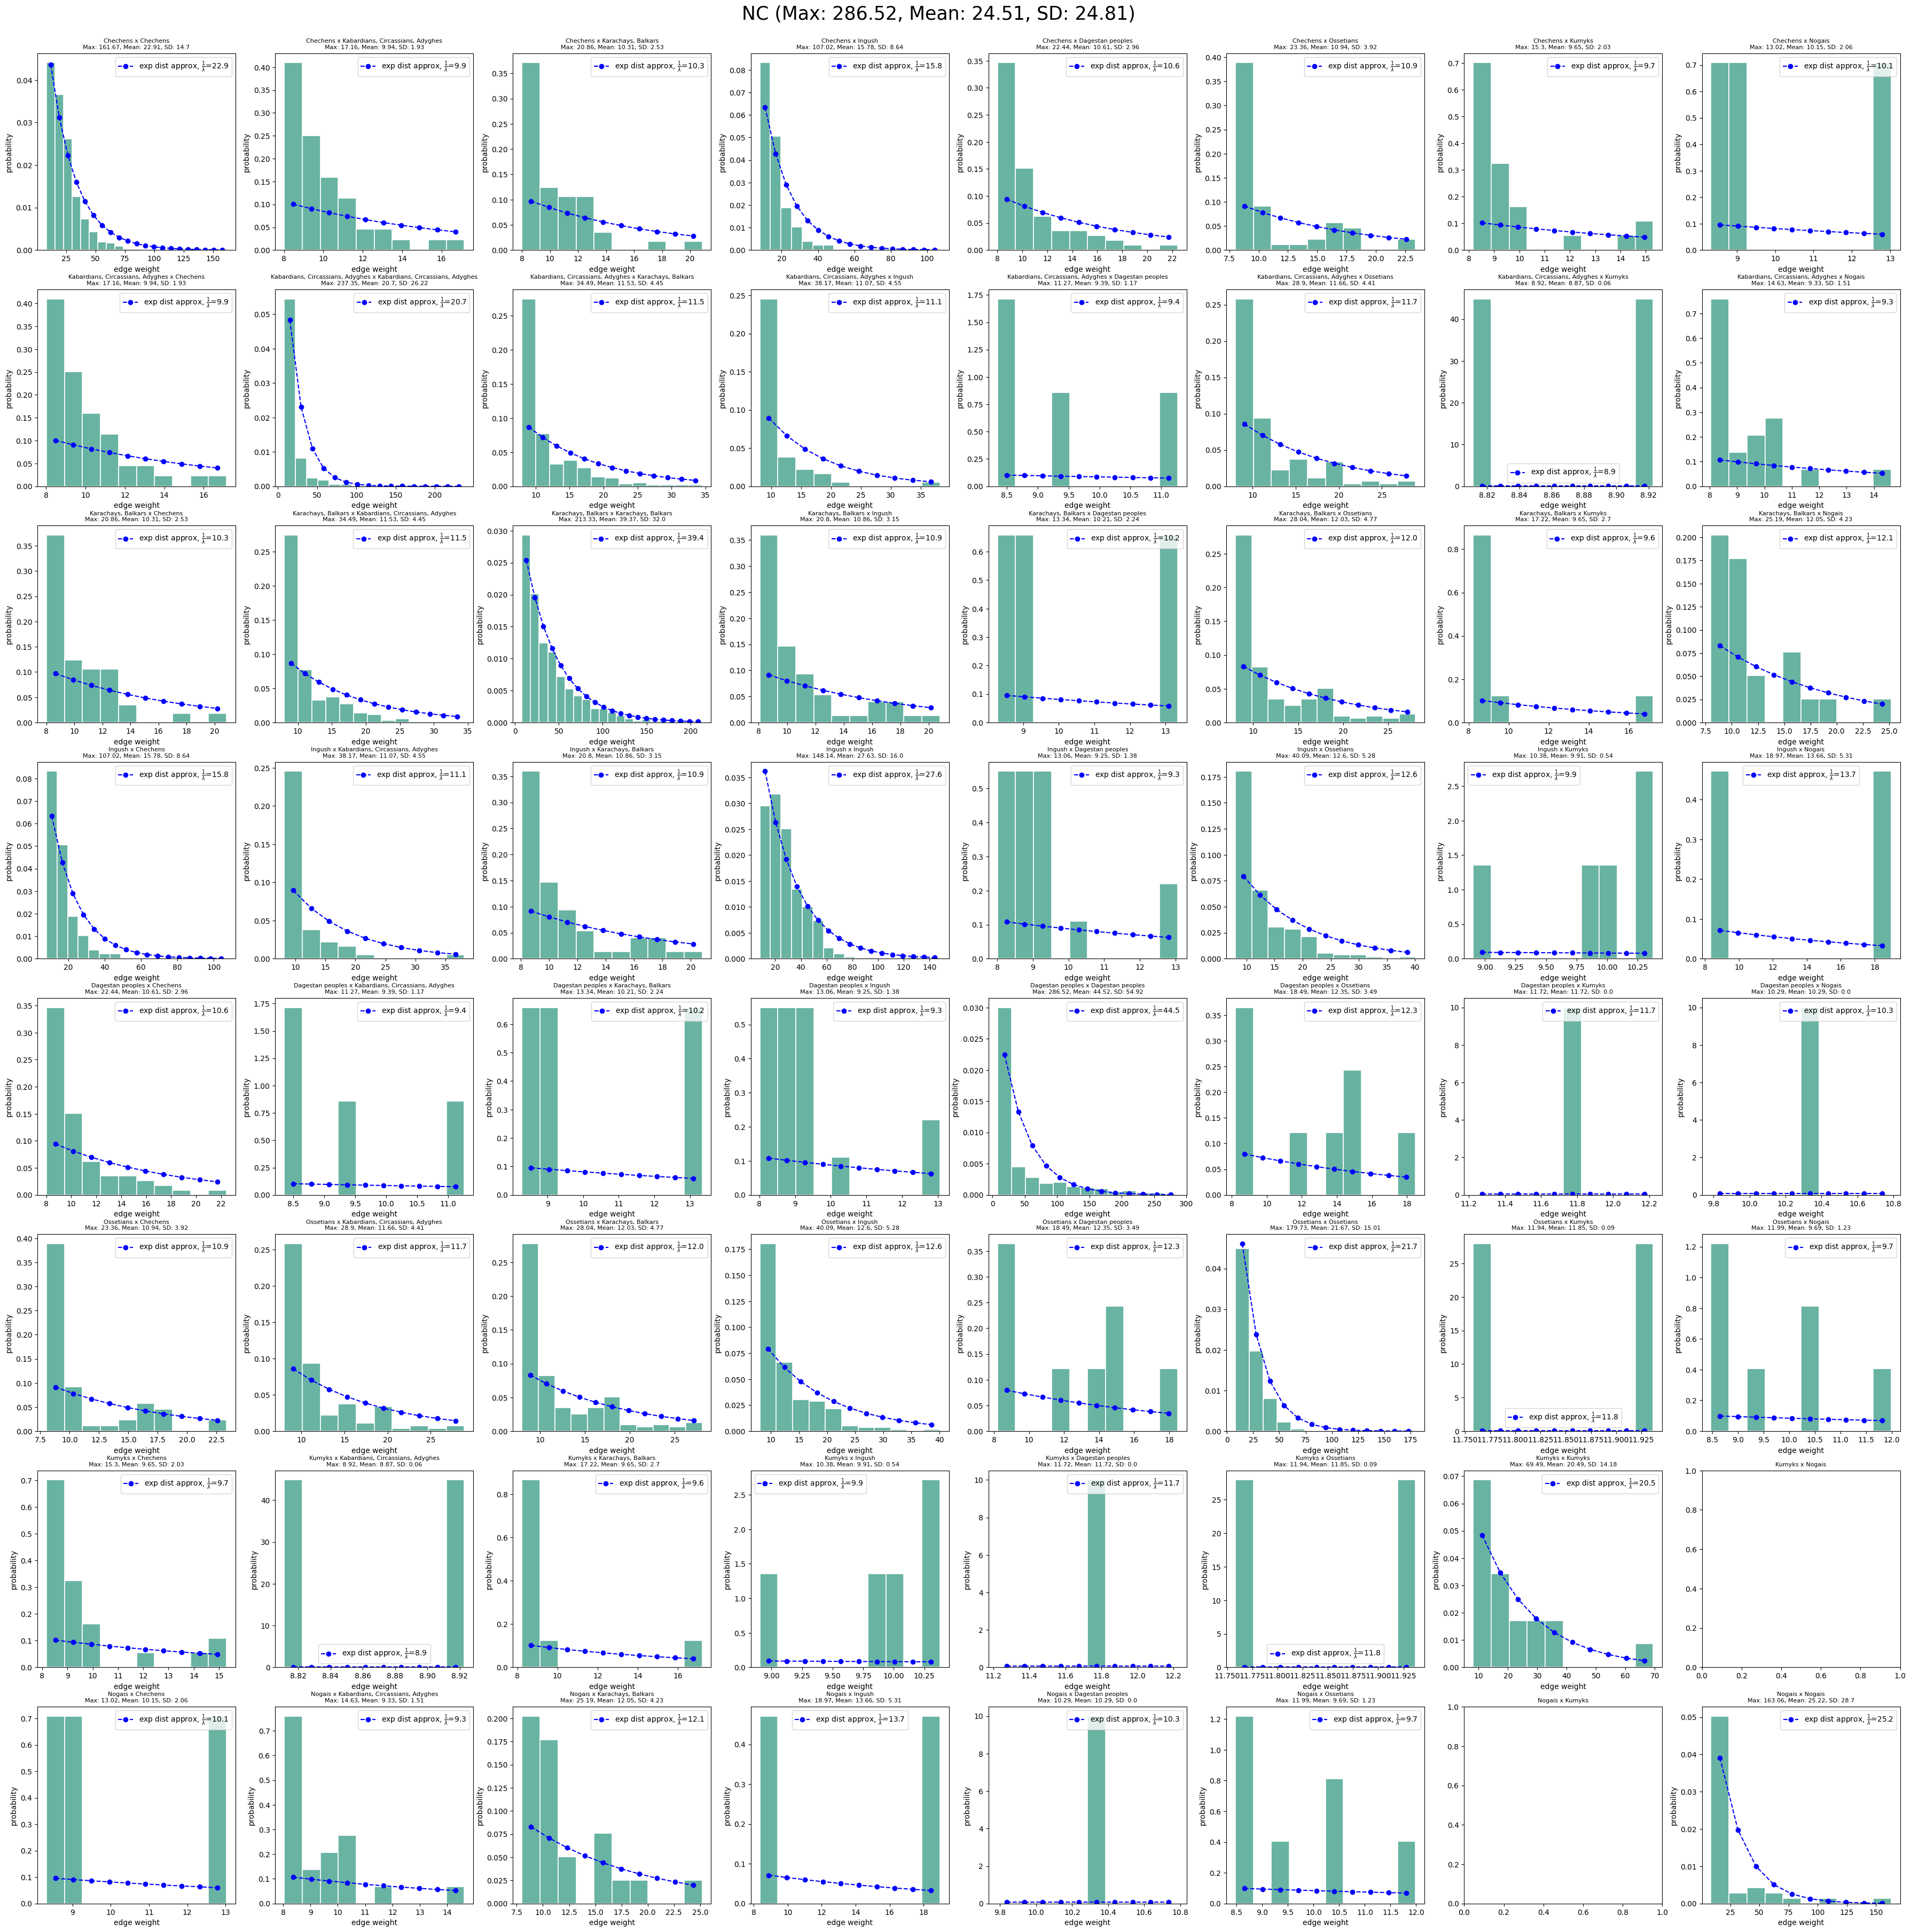

In [5]:
dp.plot_edge_weight_distribution(fig_size=(45, 45), dataset_name='NC', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/NC_dataset_weight_dist.pdf',
                                 title_pos=0.9, title_font_size=25)

In [6]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/Scandinavia.csv')

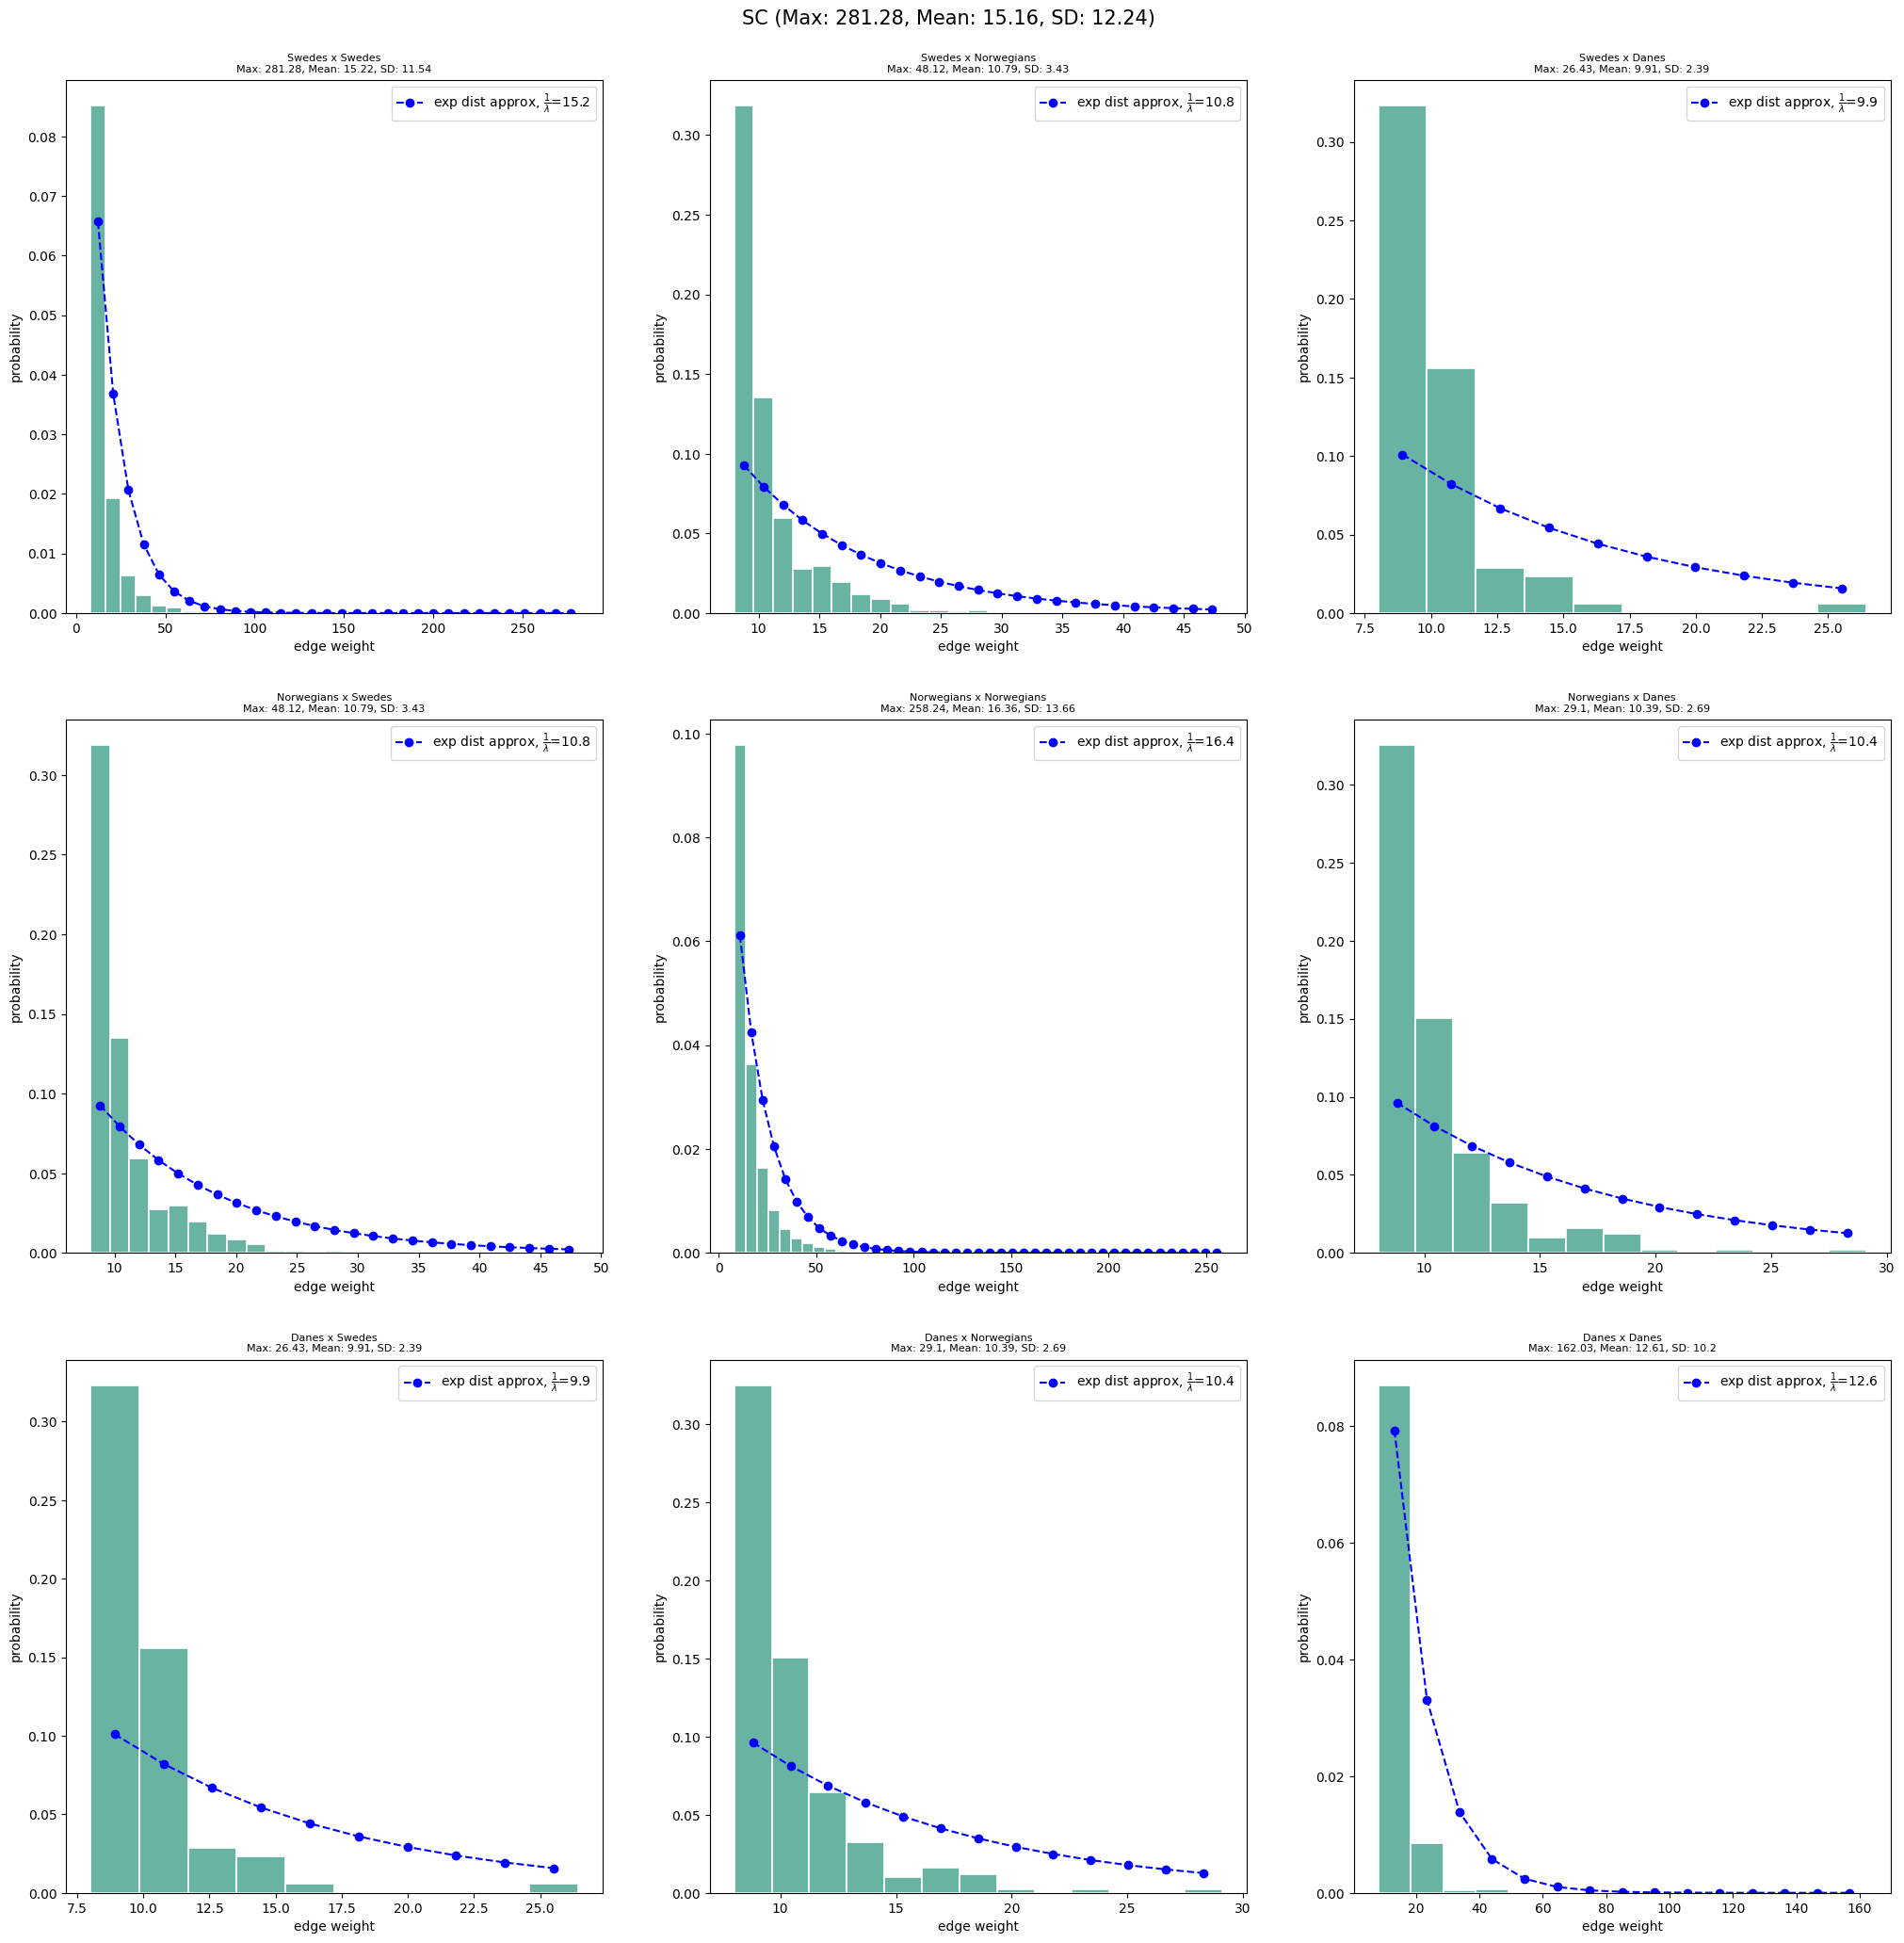

In [7]:
dp.plot_edge_weight_distribution(fig_size=(25, 25), dataset_name='SC', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/SC_dataset_weight_dist.pdf',
                                 title_pos=0.91, title_font_size=15)

In [8]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/Volga.csv')

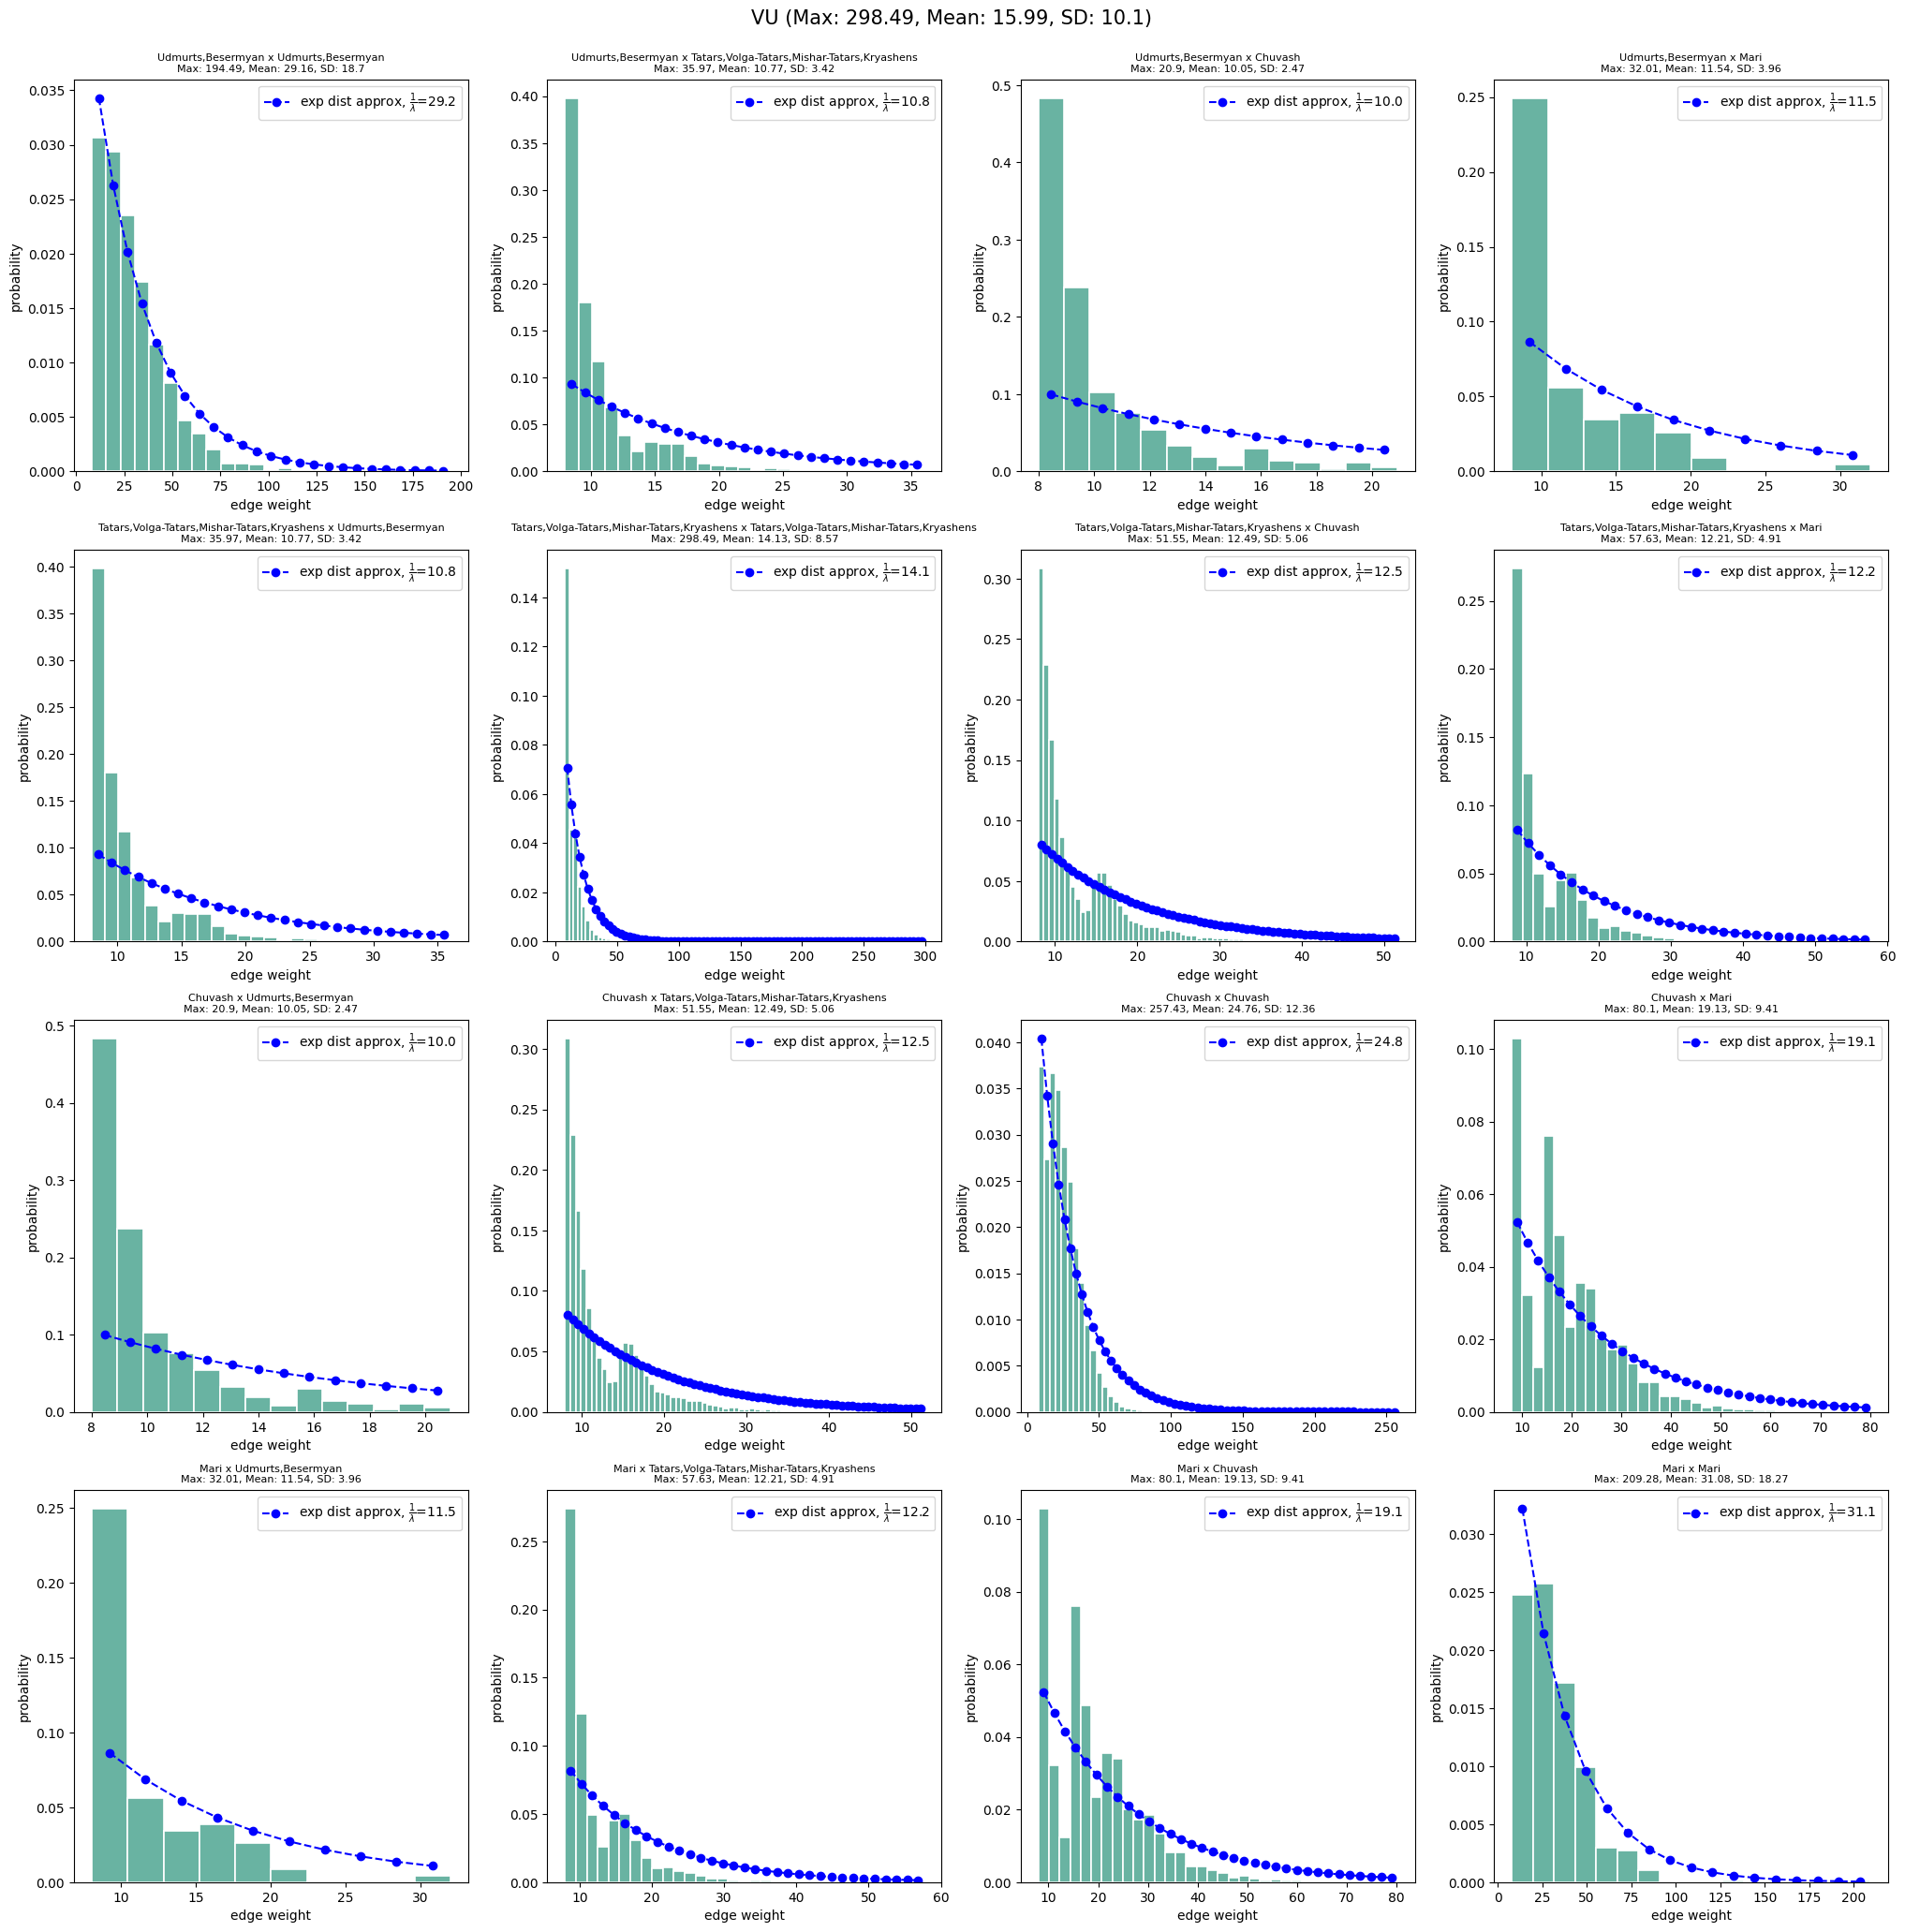

In [9]:
dp.plot_edge_weight_distribution(fig_size=(25, 25), dataset_name='VU', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/VU_dataset_weight_dist.pdf',
                                 title_pos=0.91, title_font_size=15)

# Modularity figs

In [10]:
import sys
import os
import torch
import pickle
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), os.path.pardir)))
from utils.genlink import DataProcessor, NullSimulator, Trainer

In [11]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/Volga.csv')

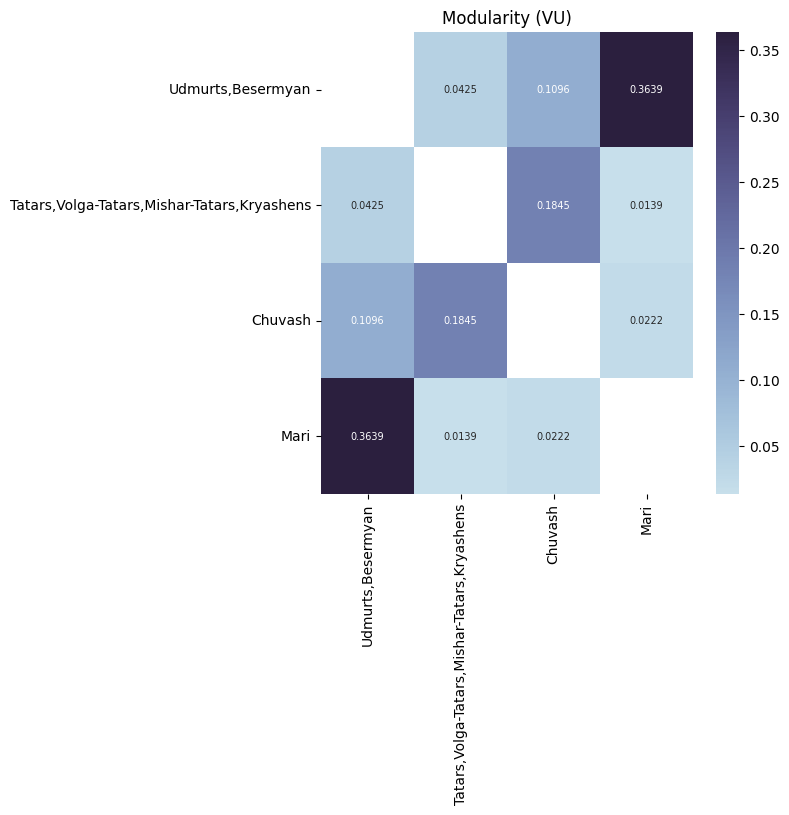

In [12]:
dp.plot_modularity_matrix(dataset_name='VU', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/VU_modularity.pdf')

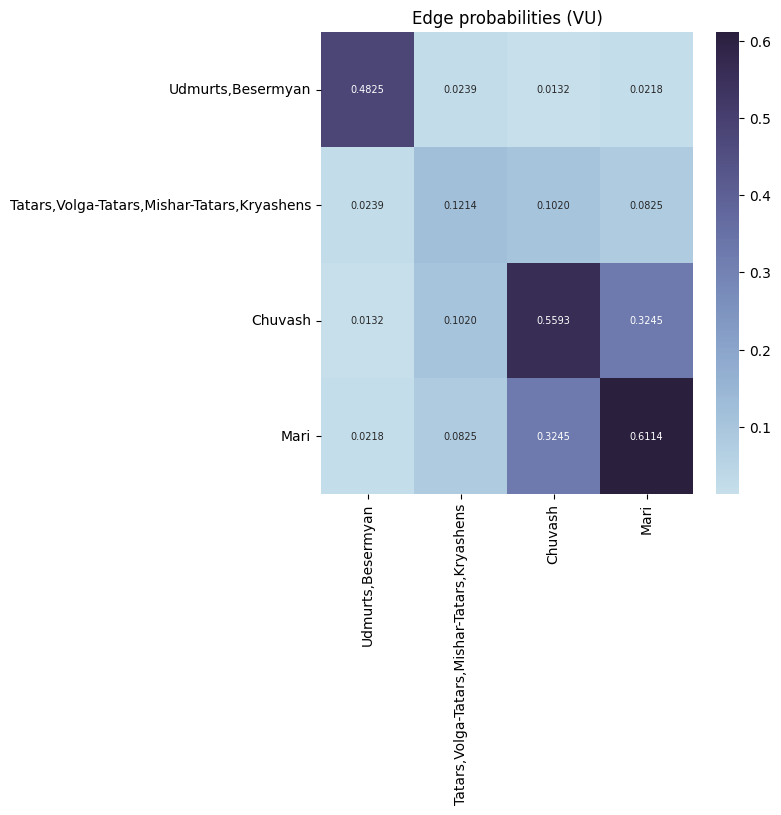

In [13]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='VU', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/VU_edge_prob.pdf')

In [14]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/NC_graph_rel_eng.csv')

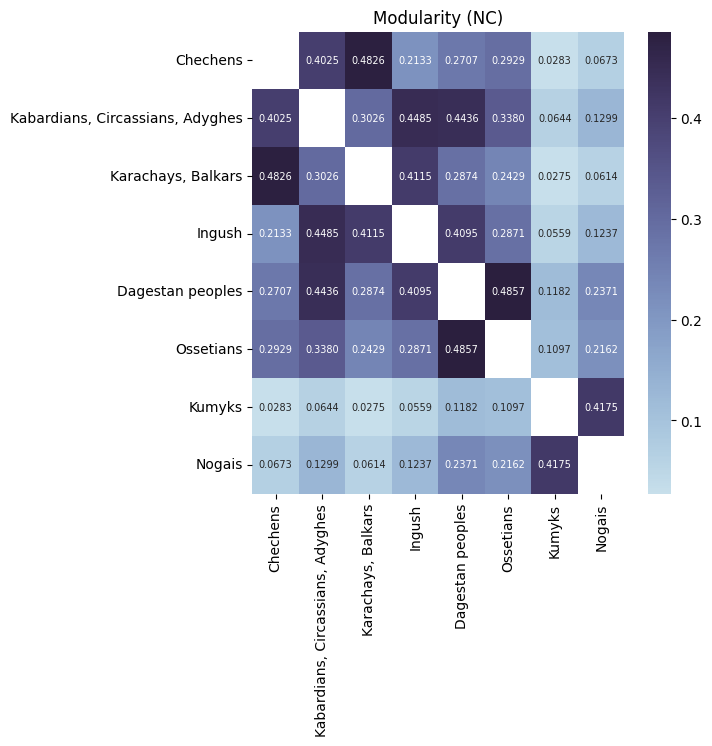

In [15]:
dp.plot_modularity_matrix(dataset_name='NC', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/NC_modularity.pdf')

/mnt/10tb/home/shmelev/GENLINK/utils/genlink.py:1341: RuntimeWarning: Mean of empty slice.
  self.mean_weight[i, j] = real_connections_df['ibd_sum'].to_numpy().mean()# - self.offset
/mnt/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/10tb/home/shmelev/GENLINK/utils/genlink.py:1341: RuntimeWarning: Mean of empty slice.
  self.mean_weight[i, j] = real_connections_df['ibd_sum'].to_numpy().mean()# - self.offset
/mnt/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


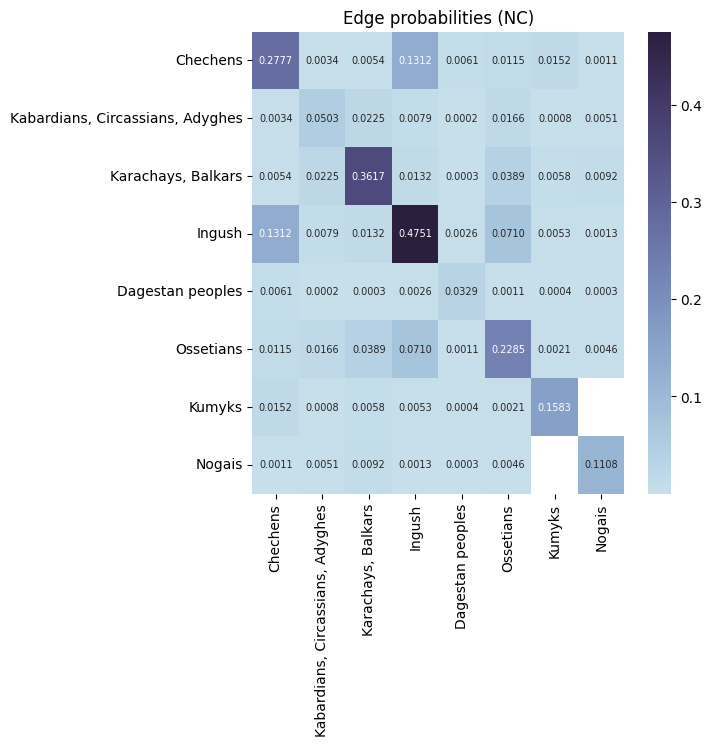

In [16]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='NC', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/NC_edge_prob.pdf')

In [17]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/Scandinavia.csv')

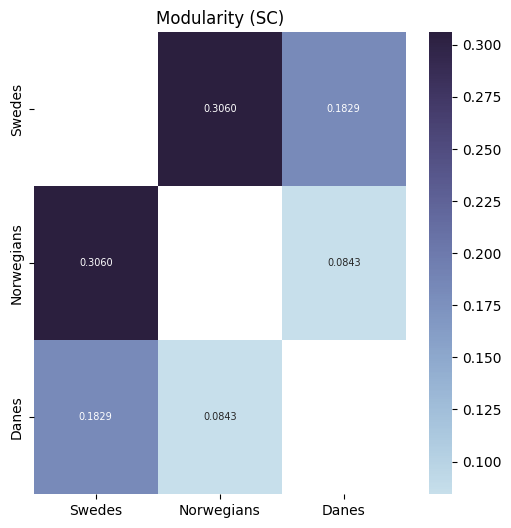

In [18]:
dp.plot_modularity_matrix(dataset_name='SC', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/SC_modularity.pdf')

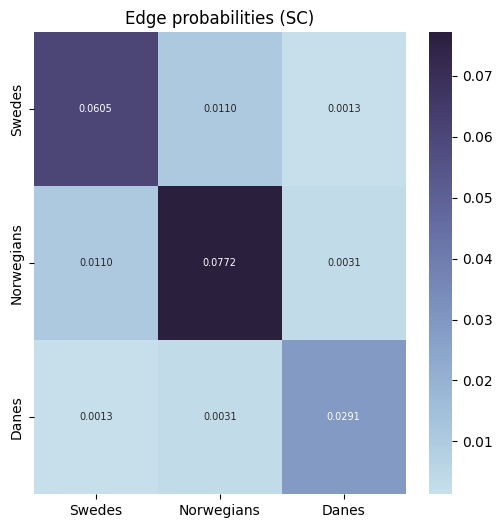

In [19]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='SC', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/SC_edge_prob.pdf')

In [20]:
dp = DataProcessor('/mnt/10tb/home/shmelev/genlink_real_data/Western-Europe.csv')

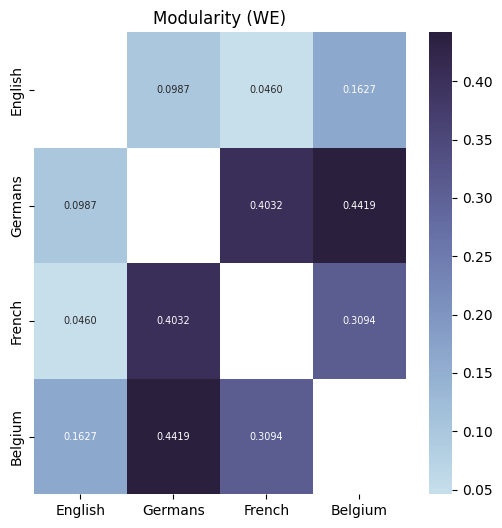

In [21]:
dp.plot_modularity_matrix(dataset_name='WE', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/WE_modularity.pdf')

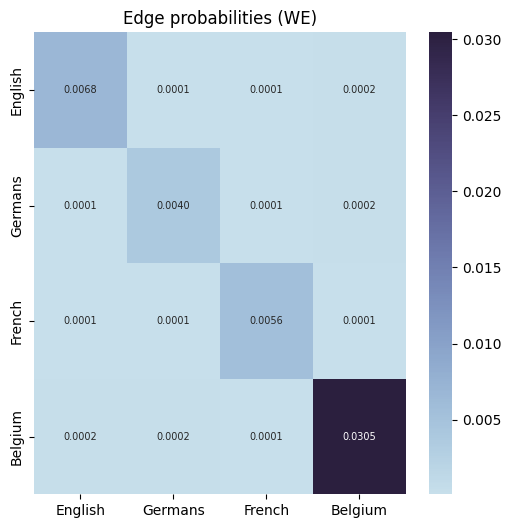

In [22]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='WE', save_path='/mnt/10tb/home/shmelev/GENLINK/pictures/WE_edge_prob.pdf')